<a href="https://colab.research.google.com/github/lrrong2020/A/blob/main/FYP_Pro_T4_overfit_solve_03_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Prep

In [2]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/data.zip /home
%cd /home
!unzip -nq /home/data.zip "train/*"





/home


In [3]:
!rm /home/data.zip


#GitHub

In [4]:
import pandas as pd #For reading csv files.
import numpy as np
import os
import matplotlib.pyplot as plt #For plotting.
import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader #For working with data.
from torchvision import models,transforms #For pretrained models,image transformations.
from torch.optim.lr_scheduler import StepLR

#manual seed for reproductivity and potential performance improvement
torch.manual_seed(3407)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [12]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/allLabels.csv /home

In [13]:

path = "/home/"

#label csv
all_df = pd.read_csv(f"{path}allLabels.csv")

from sklearn.model_selection import train_test_split
# subset for hyperparameters tuning

part = 0.80
train_df, drop_df = train_test_split(all_df, test_size=part, random_state=42)
test_sample_size = round(7000 * (1 - part) )  #roughtly 1/3
train_df, test_df = train_test_split(train_df, test_size=test_sample_size, random_state=42)

# Assuming train_df is your original training DataFrame
# test_sample_size = 7000 # roughtly 1/3
# train_df, test_df = train_test_split(all_df, test_size=test_sample_size, random_state=42)

# Now split the remaining training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'No.of.training_samples: {len(train_df)}')
print(f'No.of.testing_samples: {len(test_df)}')
print(f'No.of.val_samples: {len(valid_df)}')

No.of.training_samples: 5062
No.of.testing_samples: 1400
No.of.val_samples: 563


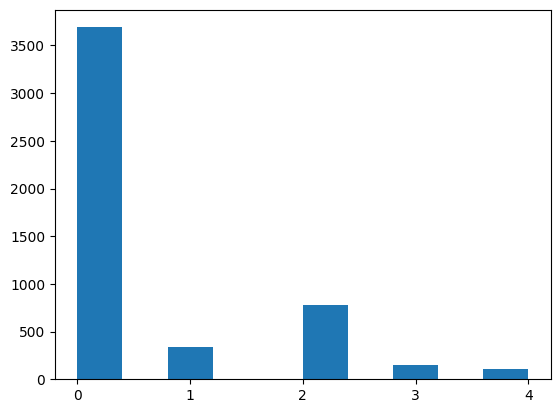

In [14]:
#Histogram of label counts.
train_df.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

In [15]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([0.2743, 2.9776, 1.3030, 6.9342, 9.3741], device='cuda:0')


In [ ]:
#For getting a random image from our training set.
# num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
# sample_image = (f'{path}train/{train_df["image"][num]}.jpeg')#Image file.
# sample_image = Image.open(sample_image)
# plt.imshow(sample_image)
# plt.axis('off')
# plt.title(f'Class: {train_df["level"][num]}') #Class of the random image.
# plt.show()

In [16]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class.

    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''

    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.

    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.

        if self.train :
            label = self.df['level'][index] #Label.
            return image,label #If train == True, return image & label.

        else:
            return image #If train != True, return image.


In [17]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_set = dataset(train_df,f'{path}train',image_transform=image_transform)
test_set = dataset(test_df,f'{path}train',image_transform=image_transform)
valid_set = dataset(valid_df,f'{path}train',image_transform=image_transform)

In [18]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4)

In [19]:
from torchvision.models import resnet50,ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT) #Downloads the resnet50 model which is pretrained on Imagenet dataset.
# Replace the Final layer of pretrained resnet50
model.fc = nn.Sequential(
    nn.Linear(2048, 5),
)

100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [20]:
model = model.to(device) #Moves the model to the device.

In [27]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.


        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        accuracy = 100*(correct/total)

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.

        #for memory
        torch.cuda.empty_cache()

        # Print some information every 100 batches
        if batch % 70 == 0:
            print(f'Batch {batch}/{len(dataloader)} processed, running loss: {running_loss:.6f}, correct predictions: {correct}, total: {total}')


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    torch.save(model, '/content/gdrive/MyDrive/Kaggle/unzip/DR_ResNet50_05adam.pt')
    return avg_loss, accuracy

In [22]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad(): #No need to calculate the gradients.

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            accuracy = 100*(correct/total)

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss, accuracy

In [23]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'g', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [25]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Initialize the learning rate scheduler
    # scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    best_valid_loss = float('inf')
    no_improve_epoch = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        print("Epoch: %d, Learning Rate: %f " % (epoch, optimizer.param_groups[0]['lr']))
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer)
        valid_loss, valid_accuracy = validate(valid_dataloader,model,loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)


        # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improve_epoch = 0

            # Save the model when validation loss improves
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve_epoch += 1

        # If the validation loss did not improve for 'patience' epochs, stop training
        if no_improve_epoch >= patience:
            print(f'Early stopping at epoch {epoch+1}, the validation loss did not improve for the last {patience} epochs')

            # Save to CSV
            df.to_csv('training_validation_metrics.csv', index=False)
            break

        # Step the learning rate scheduler
        # scheduler.step()
        scheduler.step(valid_loss)

        df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)

    print('\nTraining has completed!')

    # Save to CSV
    df.to_csv('training_validation_metrics.csv', index=False)

    return train_losses,valid_losses


Epoch 1/50
-------------------------------
Epoch: 0, Learning Rate: 0.005000 
Batch 0/317 processed, running loss: 1.833310, correct predictions: 4, total: 16
Batch 70/317 processed, running loss: 208.198924, correct predictions: 302, total: 1136
Batch 140/317 processed, running loss: 379.189442, correct predictions: 480, total: 2256
Batch 210/317 processed, running loss: 538.909800, correct predictions: 988, total: 3376
Batch 280/317 processed, running loss: 669.515680, correct predictions: 1763, total: 4496

Training Loss per batch = 2.353519	Accuracy on Training set = 42.078230% [2130/5062]

Validation Loss per batch = 2.001831	Accuracy on Validation set = 73.357016% [413/563]
Train Loss: 2.3535, Train Accuracy: 42.0782
Valid Loss: 2.0018, Valid Accuracy: 73.3570


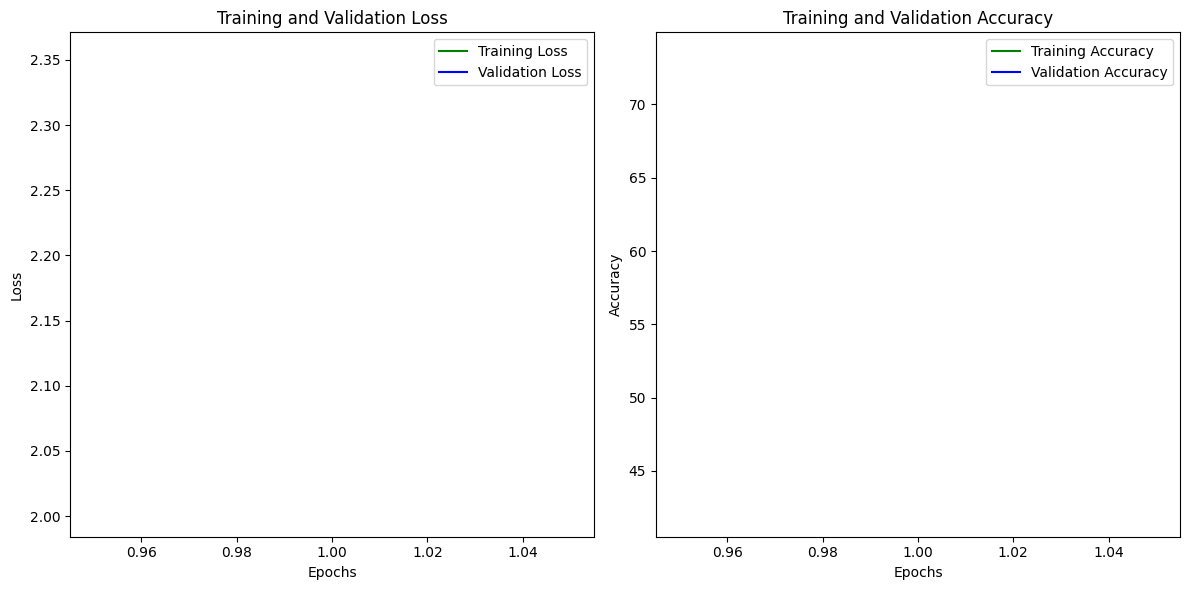


Epoch 2/50
-------------------------------
Epoch: 1, Learning Rate: 0.005000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.733580, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 139.898797, correct predictions: 745, total: 1136
Batch 140/317 processed, running loss: 266.417998, correct predictions: 1512, total: 2256
Batch 210/317 processed, running loss: 387.372834, correct predictions: 2290, total: 3376
Batch 280/317 processed, running loss: 510.215414, correct predictions: 3049, total: 4496

Training Loss per batch = 1.787197	Accuracy on Training set = 68.194390% [3452/5062]

Validation Loss per batch = 1.827827	Accuracy on Validation set = 73.179396% [412/563]
Train Loss: 1.7872, Train Accuracy: 68.1944
Valid Loss: 1.8278, Valid Accuracy: 73.1794


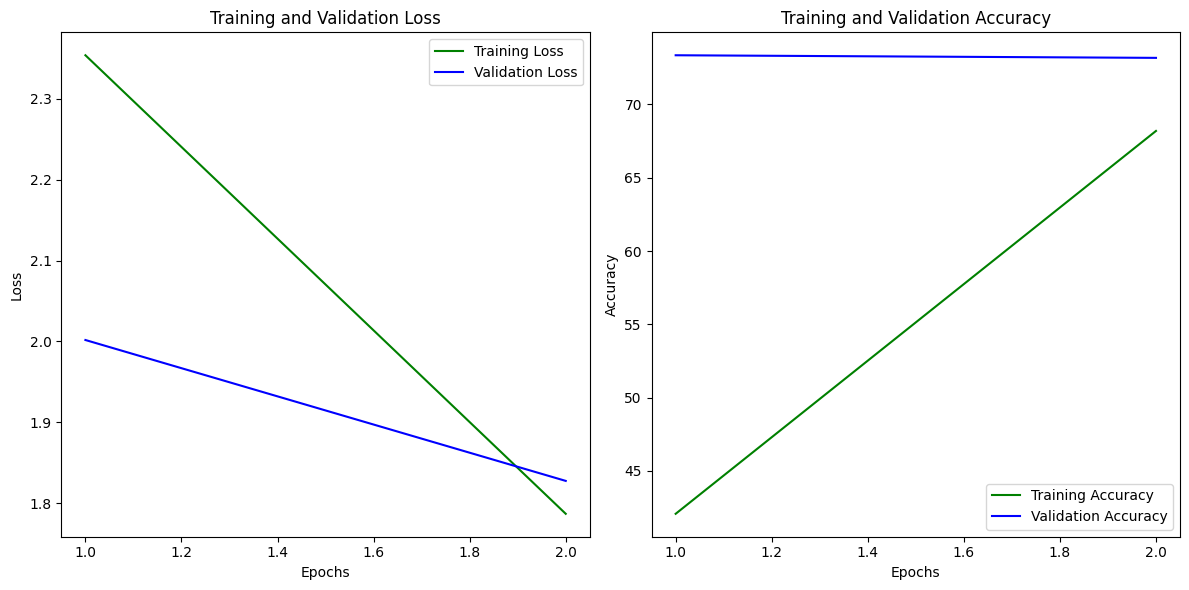


Epoch 3/50
-------------------------------
Epoch: 2, Learning Rate: 0.005000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.982000, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 117.013000, correct predictions: 787, total: 1136
Batch 140/317 processed, running loss: 241.623601, correct predictions: 1559, total: 2256
Batch 210/317 processed, running loss: 356.909625, correct predictions: 2341, total: 3376
Batch 280/317 processed, running loss: 473.038402, correct predictions: 3103, total: 4496

Training Loss per batch = 1.675741	Accuracy on Training set = 69.083366% [3497/5062]

Validation Loss per batch = 4.565973	Accuracy on Validation set = 68.561279% [386/563]
Train Loss: 1.6757, Train Accuracy: 69.0834
Valid Loss: 4.5660, Valid Accuracy: 68.5613


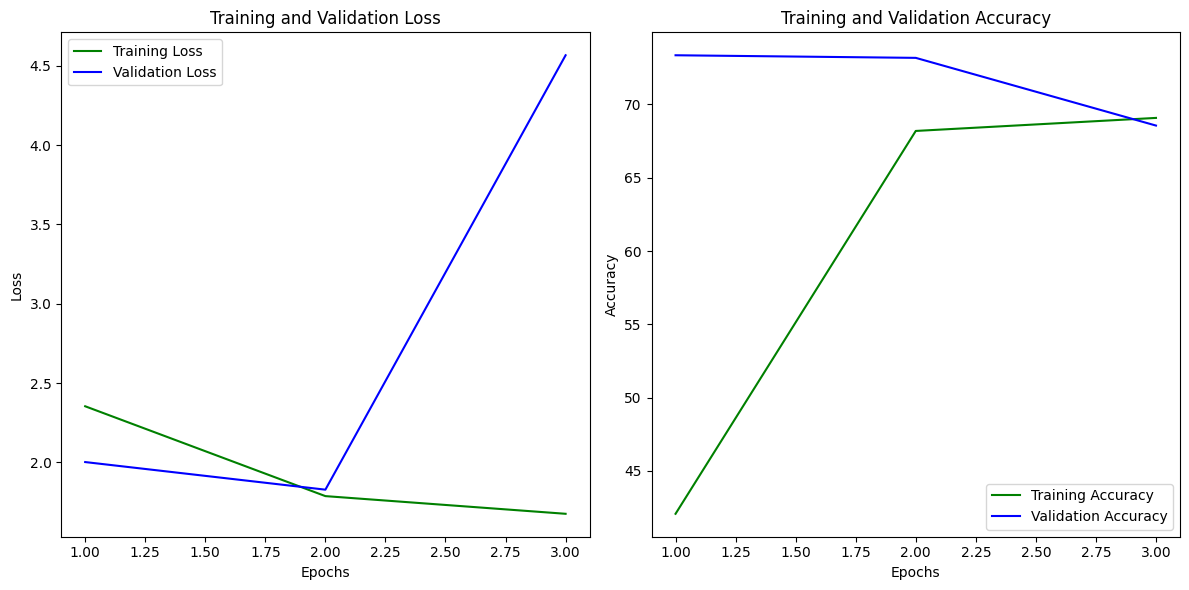


Epoch 4/50
-------------------------------
Epoch: 3, Learning Rate: 0.005000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.388799, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 116.172746, correct predictions: 776, total: 1136
Batch 140/317 processed, running loss: 228.671014, correct predictions: 1552, total: 2256
Batch 210/317 processed, running loss: 345.629914, correct predictions: 2324, total: 3376
Batch 280/317 processed, running loss: 461.657599, correct predictions: 3094, total: 4496

Training Loss per batch = 1.642295	Accuracy on Training set = 68.629000% [3474/5062]

Validation Loss per batch = 10.745469	Accuracy on Validation set = 62.877442% [354/563]
Train Loss: 1.6423, Train Accuracy: 68.6290
Valid Loss: 10.7455, Valid Accuracy: 62.8774


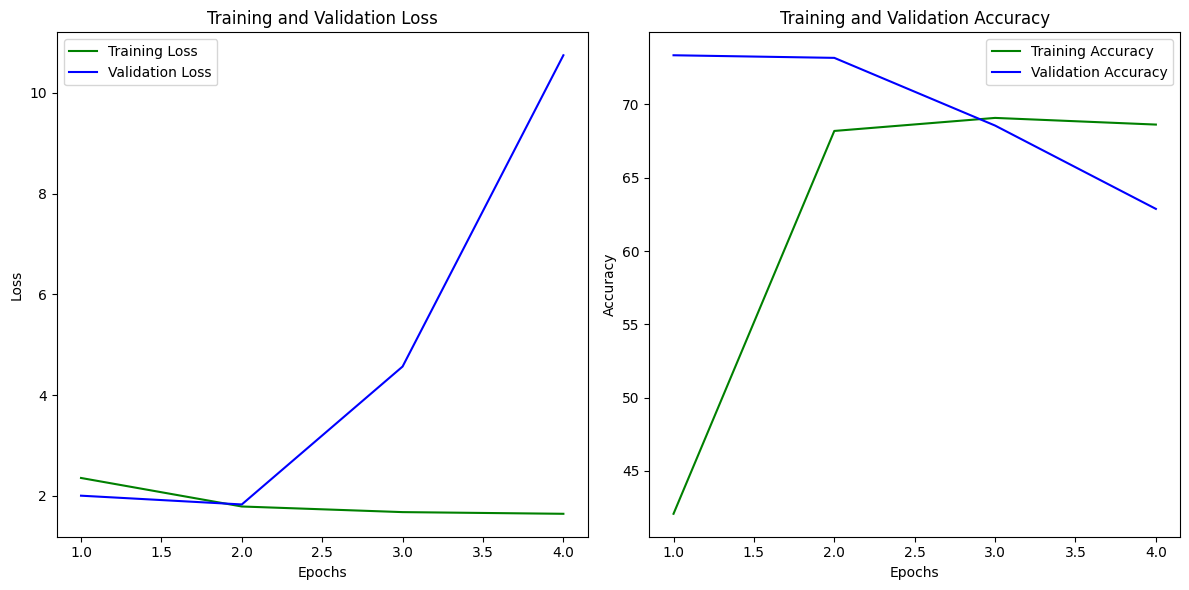


Epoch 5/50
-------------------------------
Epoch: 4, Learning Rate: 0.005000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 4.172913, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 123.828771, correct predictions: 763, total: 1136
Batch 140/317 processed, running loss: 250.968296, correct predictions: 1513, total: 2256
Batch 210/317 processed, running loss: 363.600279, correct predictions: 2270, total: 3376
Batch 280/317 processed, running loss: 476.253512, correct predictions: 3067, total: 4496

Training Loss per batch = 1.688391	Accuracy on Training set = 67.937574% [3439/5062]

Validation Loss per batch = 1.564367	Accuracy on Validation set = 69.626998% [392/563]
Train Loss: 1.6884, Train Accuracy: 67.9376
Valid Loss: 1.5644, Valid Accuracy: 69.6270


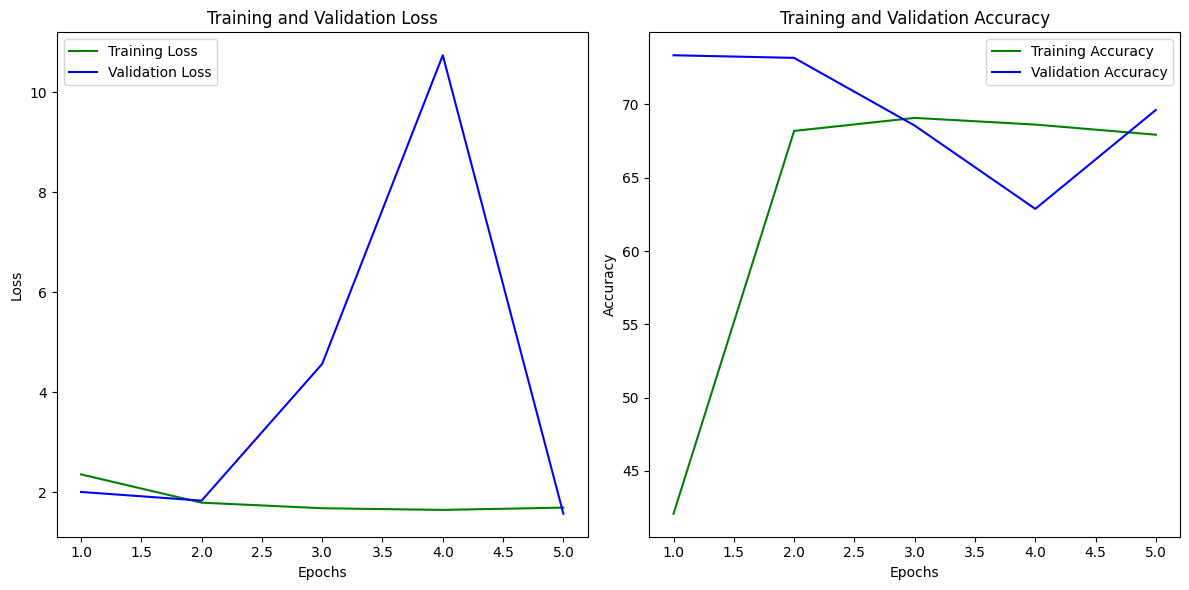


Epoch 6/50
-------------------------------
Epoch: 5, Learning Rate: 0.005000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.404124, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 113.859442, correct predictions: 771, total: 1136
Batch 140/317 processed, running loss: 228.011140, correct predictions: 1045, total: 2256
Batch 210/317 processed, running loss: 344.439674, correct predictions: 1765, total: 3376
Batch 280/317 processed, running loss: 473.189298, correct predictions: 2504, total: 4496

Training Loss per batch = 1.691636	Accuracy on Training set = 55.590676% [2814/5062]

Validation Loss per batch = 1.982819	Accuracy on Validation set = 15.808171% [89/563]
Train Loss: 1.6916, Train Accuracy: 55.5907
Valid Loss: 1.9828, Valid Accuracy: 15.8082


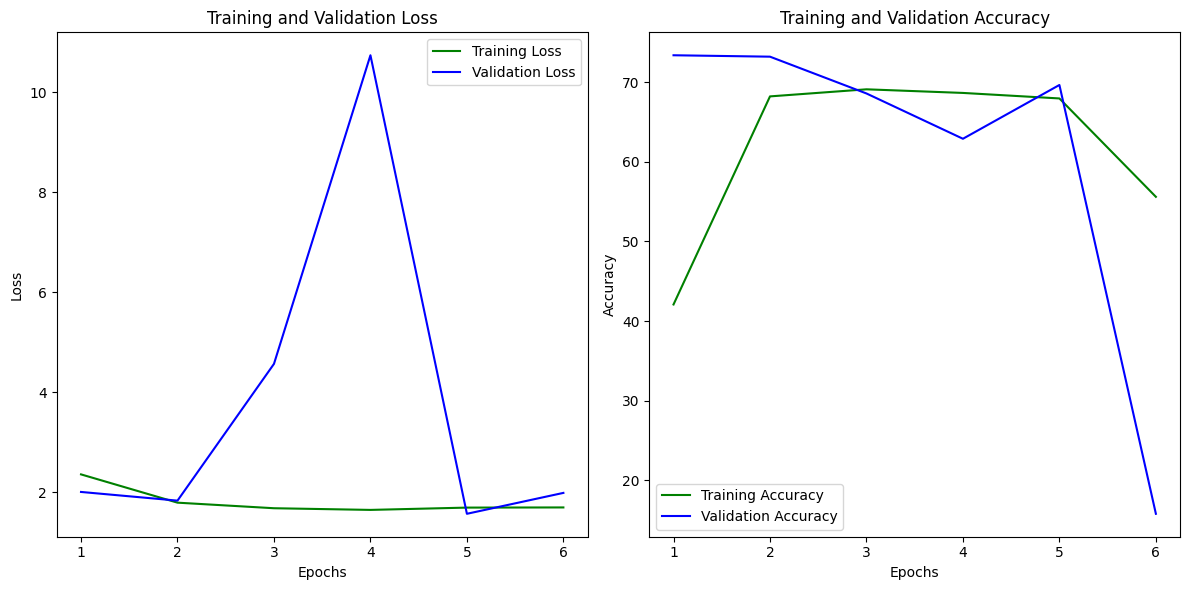


Epoch 7/50
-------------------------------
Epoch: 6, Learning Rate: 0.005000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 3.791604, correct predictions: 8, total: 16
Batch 70/317 processed, running loss: 140.878680, correct predictions: 318, total: 1136
Batch 140/317 processed, running loss: 250.947106, correct predictions: 1142, total: 2256
Batch 210/317 processed, running loss: 366.208780, correct predictions: 1919, total: 3376
Batch 280/317 processed, running loss: 480.058210, correct predictions: 2687, total: 4496

Training Loss per batch = 1.698157	Accuracy on Training set = 60.726985% [3074/5062]

Validation Loss per batch = 3.093111	Accuracy on Validation set = 52.575488% [296/563]
Train Loss: 1.6982, Train Accuracy: 60.7270
Valid Loss: 3.0931, Valid Accuracy: 52.5755


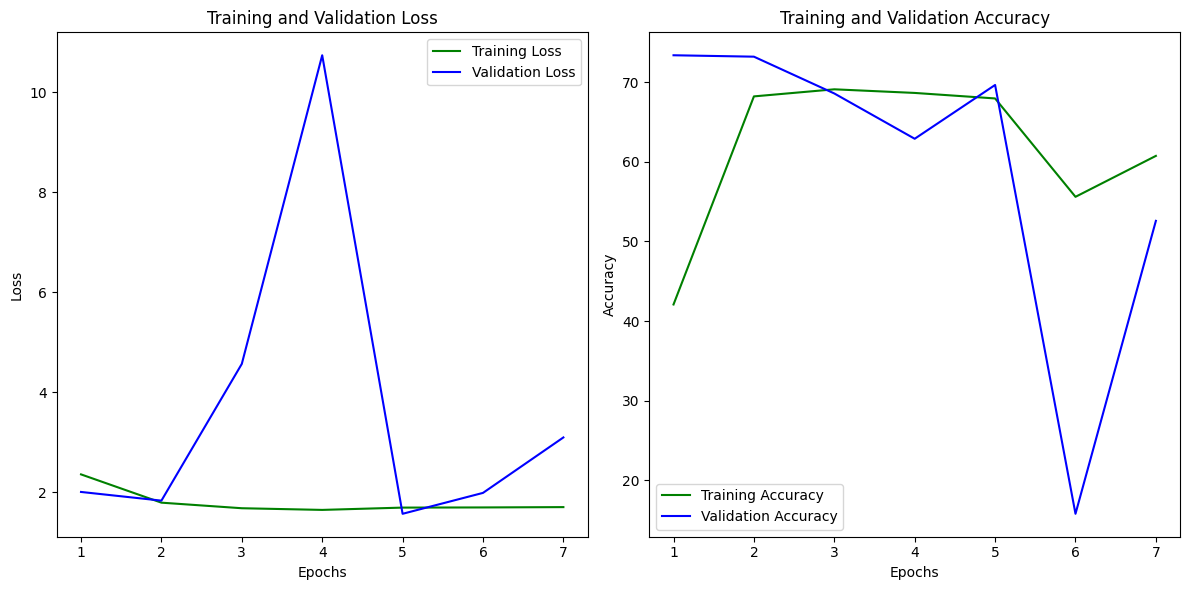


Epoch 8/50
-------------------------------
Epoch: 7, Learning Rate: 0.005000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.729030, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 116.487126, correct predictions: 759, total: 1136
Batch 140/317 processed, running loss: 233.029313, correct predictions: 1527, total: 2256
Batch 210/317 processed, running loss: 347.217559, correct predictions: 2220, total: 3376
Batch 280/317 processed, running loss: 459.596637, correct predictions: 2951, total: 4496

Training Loss per batch = 1.631095	Accuracy on Training set = 66.732517% [3378/5062]

Validation Loss per batch = 1.596980	Accuracy on Validation set = 72.468917% [408/563]
Train Loss: 1.6311, Train Accuracy: 66.7325
Valid Loss: 1.5970, Valid Accuracy: 72.4689


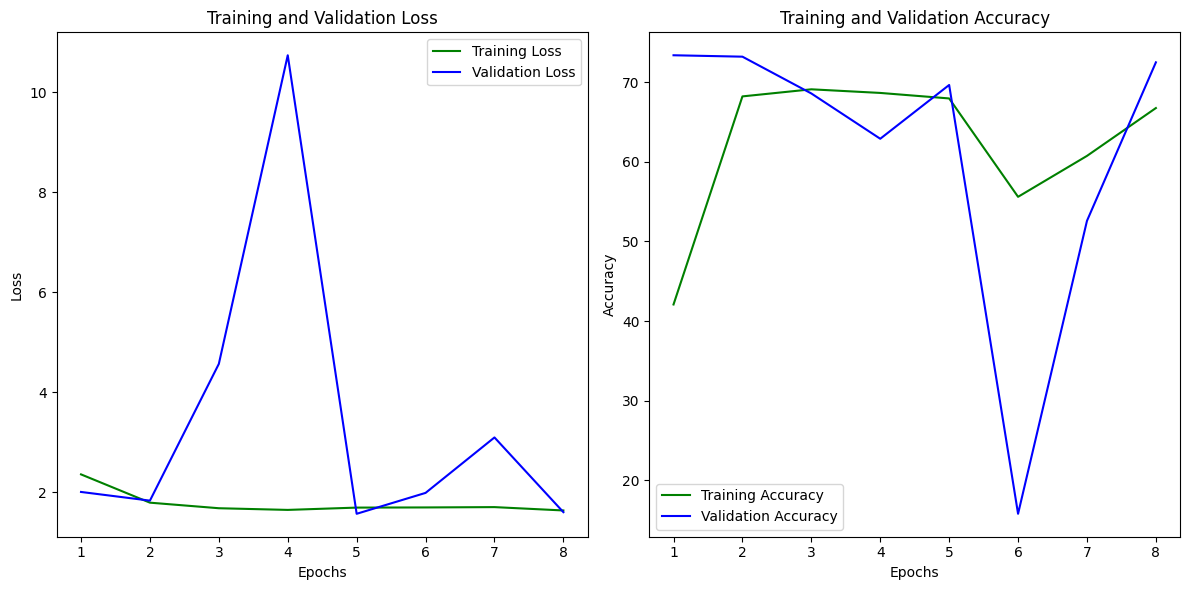


Epoch 9/50
-------------------------------
Epoch: 8, Learning Rate: 0.005000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.562431, correct predictions: 9, total: 16
Batch 70/317 processed, running loss: 117.582258, correct predictions: 753, total: 1136
Batch 140/317 processed, running loss: 230.386066, correct predictions: 1511, total: 2256
Batch 210/317 processed, running loss: 357.580428, correct predictions: 2162, total: 3376
Batch 280/317 processed, running loss: 477.740452, correct predictions: 2895, total: 4496

Training Loss per batch = 1.694217	Accuracy on Training set = 65.132359% [3297/5062]

Validation Loss per batch = 1.928865	Accuracy on Validation set = 70.337478% [396/563]
Train Loss: 1.6942, Train Accuracy: 65.1324
Valid Loss: 1.9289, Valid Accuracy: 70.3375


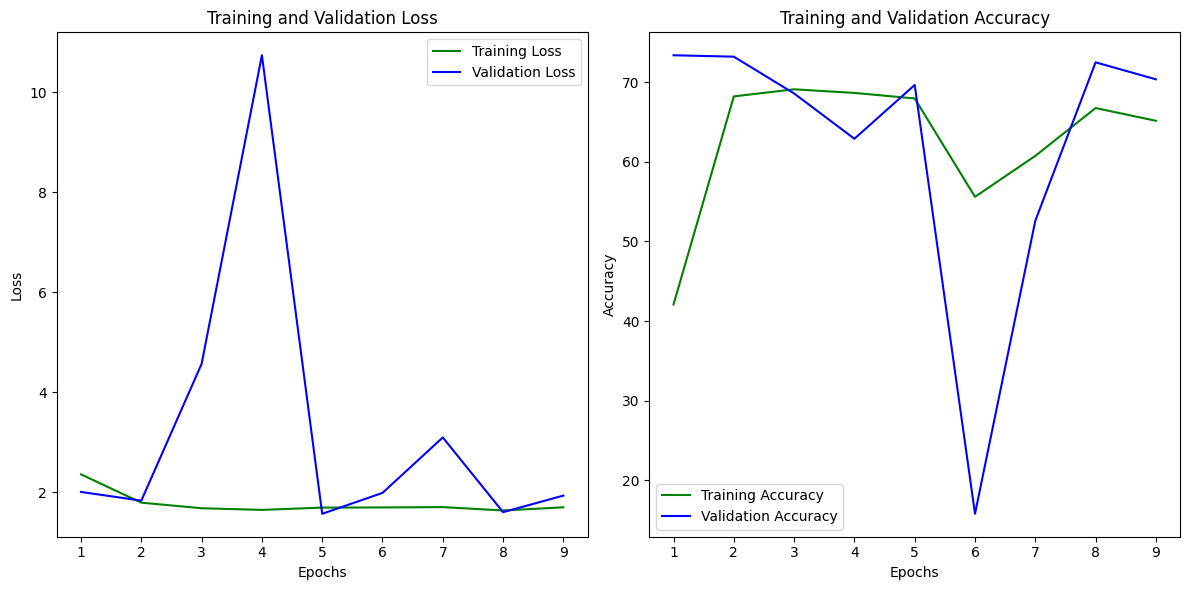


Epoch 10/50
-------------------------------
Epoch: 9, Learning Rate: 0.000500 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.618629, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 112.921414, correct predictions: 822, total: 1136
Batch 140/317 processed, running loss: 224.624805, correct predictions: 1601, total: 2256
Batch 210/317 processed, running loss: 337.483654, correct predictions: 2382, total: 3376
Batch 280/317 processed, running loss: 450.449786, correct predictions: 3172, total: 4496

Training Loss per batch = 1.600008	Accuracy on Training set = 70.406954% [3564/5062]

Validation Loss per batch = 1.712939	Accuracy on Validation set = 71.758437% [404/563]
Train Loss: 1.6000, Train Accuracy: 70.4070
Valid Loss: 1.7129, Valid Accuracy: 71.7584


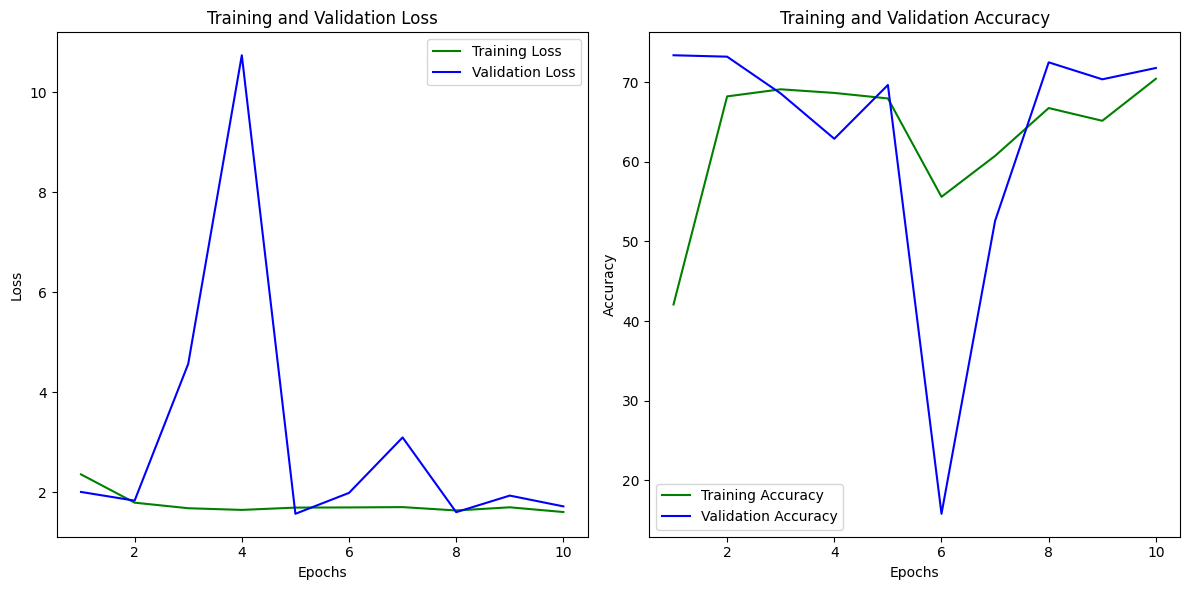


Epoch 11/50
-------------------------------
Epoch: 10, Learning Rate: 0.000500 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.398318, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 112.160382, correct predictions: 798, total: 1136
Batch 140/317 processed, running loss: 220.827881, correct predictions: 1569, total: 2256
Batch 210/317 processed, running loss: 332.726793, correct predictions: 2333, total: 3376
Batch 280/317 processed, running loss: 445.530738, correct predictions: 3151, total: 4496

Training Loss per batch = 1.586703	Accuracy on Training set = 69.873568% [3537/5062]

Validation Loss per batch = 2.297129	Accuracy on Validation set = 67.495560% [380/563]
Train Loss: 1.5867, Train Accuracy: 69.8736
Valid Loss: 2.2971, Valid Accuracy: 67.4956


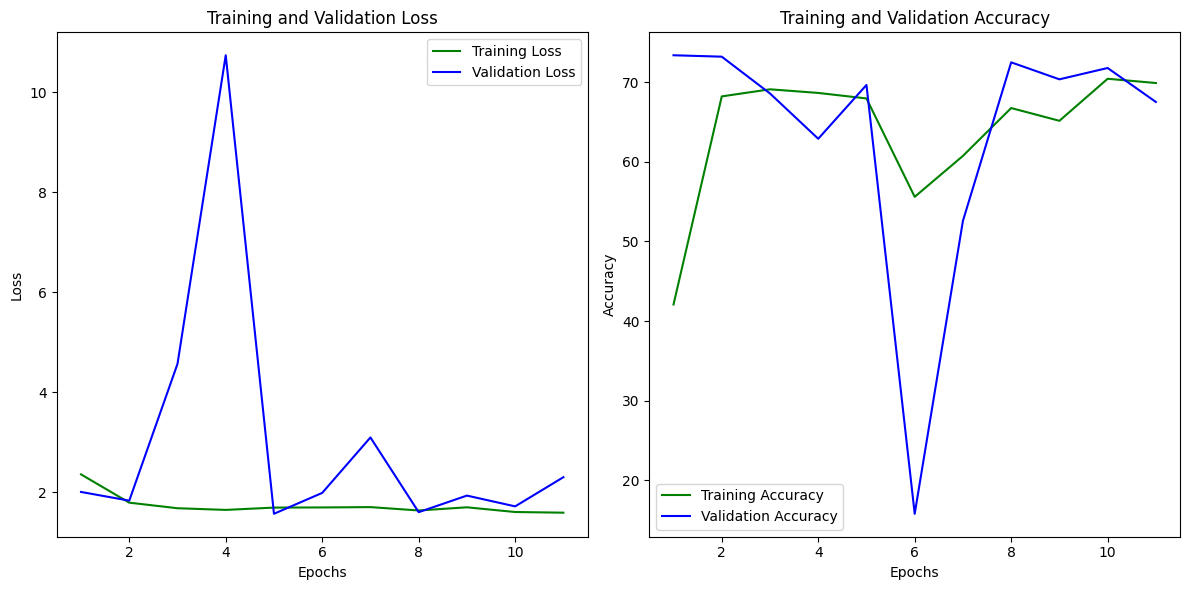


Epoch 12/50
-------------------------------
Epoch: 11, Learning Rate: 0.000500 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.561361, correct predictions: 7, total: 16
Batch 70/317 processed, running loss: 112.378699, correct predictions: 772, total: 1136
Batch 140/317 processed, running loss: 225.710316, correct predictions: 1554, total: 2256
Batch 210/317 processed, running loss: 336.557614, correct predictions: 2326, total: 3376
Batch 280/317 processed, running loss: 448.452554, correct predictions: 3114, total: 4496

Training Loss per batch = 1.592221	Accuracy on Training set = 69.755038% [3531/5062]

Validation Loss per batch = 1.779251	Accuracy on Validation set = 72.291297% [407/563]
Train Loss: 1.5922, Train Accuracy: 69.7550
Valid Loss: 1.7793, Valid Accuracy: 72.2913


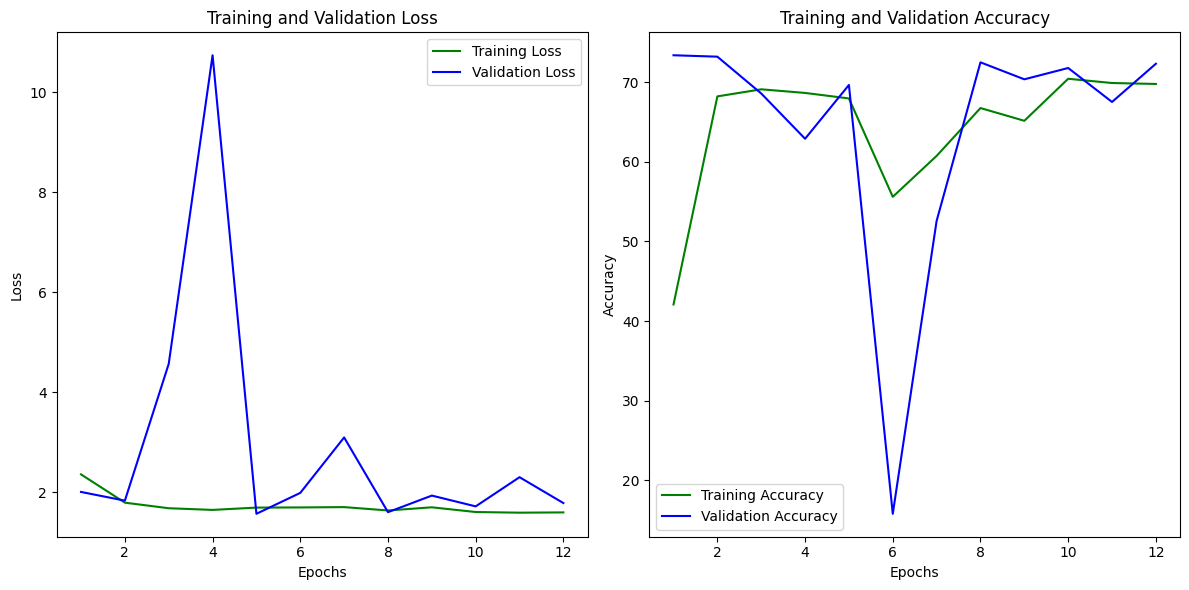


Epoch 13/50
-------------------------------
Epoch: 12, Learning Rate: 0.000500 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.580966, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 113.686856, correct predictions: 813, total: 1136
Batch 140/317 processed, running loss: 223.118028, correct predictions: 1569, total: 2256
Batch 210/317 processed, running loss: 336.762485, correct predictions: 2360, total: 3376
Batch 280/317 processed, running loss: 445.830074, correct predictions: 3167, total: 4496

Training Loss per batch = 1.584775	Accuracy on Training set = 70.841565% [3586/5062]

Validation Loss per batch = 1.643233	Accuracy on Validation set = 72.468917% [408/563]
Train Loss: 1.5848, Train Accuracy: 70.8416
Valid Loss: 1.6432, Valid Accuracy: 72.4689


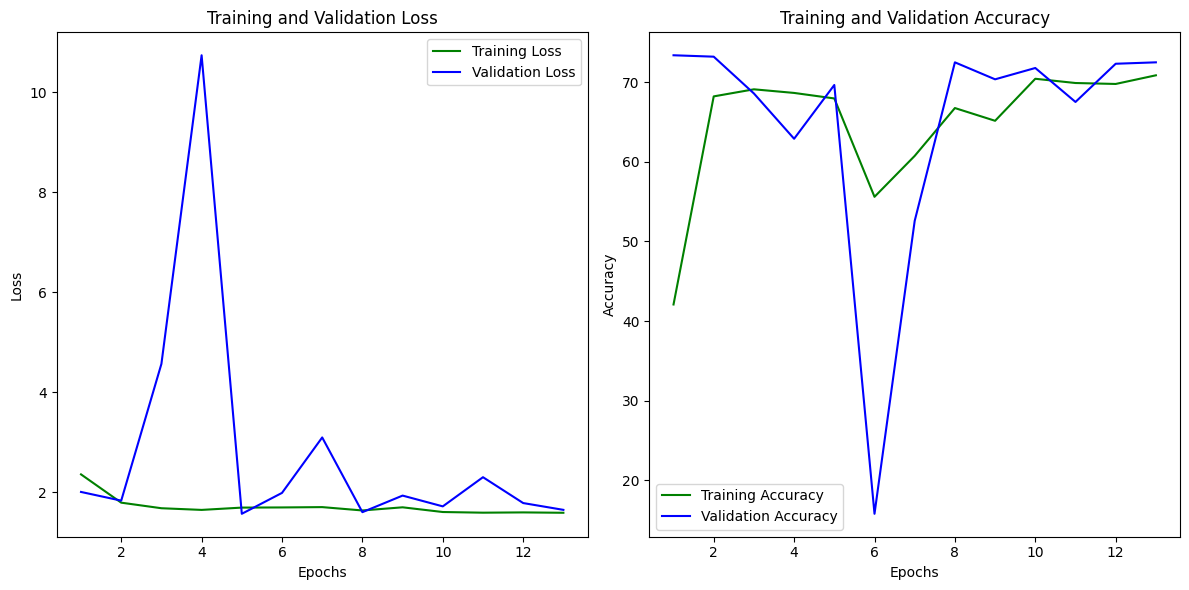


Epoch 14/50
-------------------------------
Epoch: 13, Learning Rate: 0.000050 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.389500, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 111.479453, correct predictions: 816, total: 1136
Batch 140/317 processed, running loss: 221.595748, correct predictions: 1613, total: 2256
Batch 210/317 processed, running loss: 331.179783, correct predictions: 2427, total: 3376
Batch 280/317 processed, running loss: 441.997788, correct predictions: 3237, total: 4496

Training Loss per batch = 1.575994	Accuracy on Training set = 72.224417% [3656/5062]

Validation Loss per batch = 1.642477	Accuracy on Validation set = 73.001776% [411/563]
Train Loss: 1.5760, Train Accuracy: 72.2244
Valid Loss: 1.6425, Valid Accuracy: 73.0018


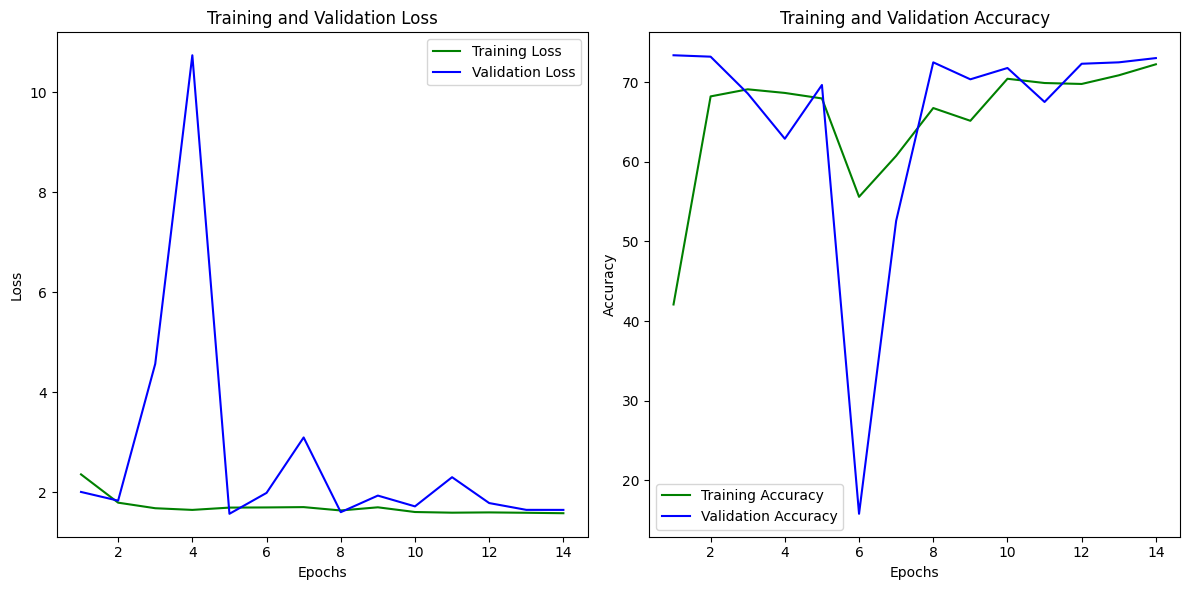


Epoch 15/50
-------------------------------
Epoch: 14, Learning Rate: 0.000050 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.589278, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 112.080634, correct predictions: 839, total: 1136
Batch 140/317 processed, running loss: 220.733090, correct predictions: 1645, total: 2256
Batch 210/317 processed, running loss: 332.697226, correct predictions: 2421, total: 3376
Batch 280/317 processed, running loss: 445.727907, correct predictions: 3214, total: 4496

Training Loss per batch = 1.588510	Accuracy on Training set = 71.473726% [3618/5062]

Validation Loss per batch = 1.641837	Accuracy on Validation set = 72.291297% [407/563]
Train Loss: 1.5885, Train Accuracy: 71.4737
Valid Loss: 1.6418, Valid Accuracy: 72.2913


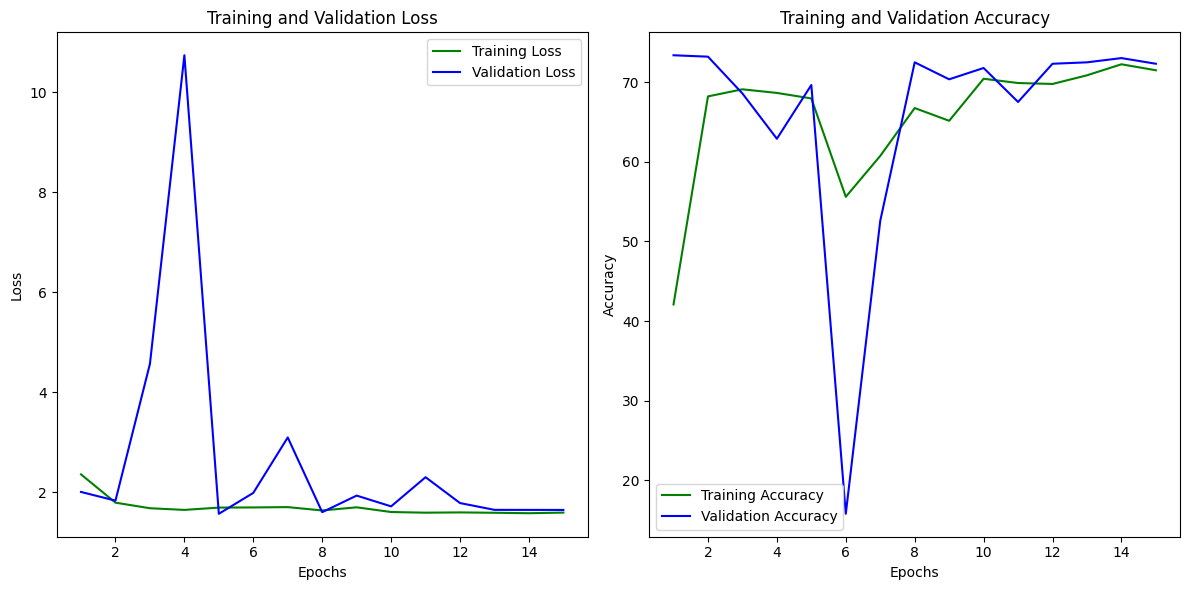


Epoch 16/50
-------------------------------
Epoch: 15, Learning Rate: 0.000050 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.364175, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 111.547422, correct predictions: 796, total: 1136
Batch 140/317 processed, running loss: 222.689985, correct predictions: 1618, total: 2256
Batch 210/317 processed, running loss: 333.540572, correct predictions: 2435, total: 3376
Batch 280/317 processed, running loss: 445.041170, correct predictions: 3251, total: 4496

Training Loss per batch = 1.587876	Accuracy on Training set = 72.105887% [3650/5062]

Validation Loss per batch = 1.633045	Accuracy on Validation set = 72.646536% [409/563]
Train Loss: 1.5879, Train Accuracy: 72.1059
Valid Loss: 1.6330, Valid Accuracy: 72.6465


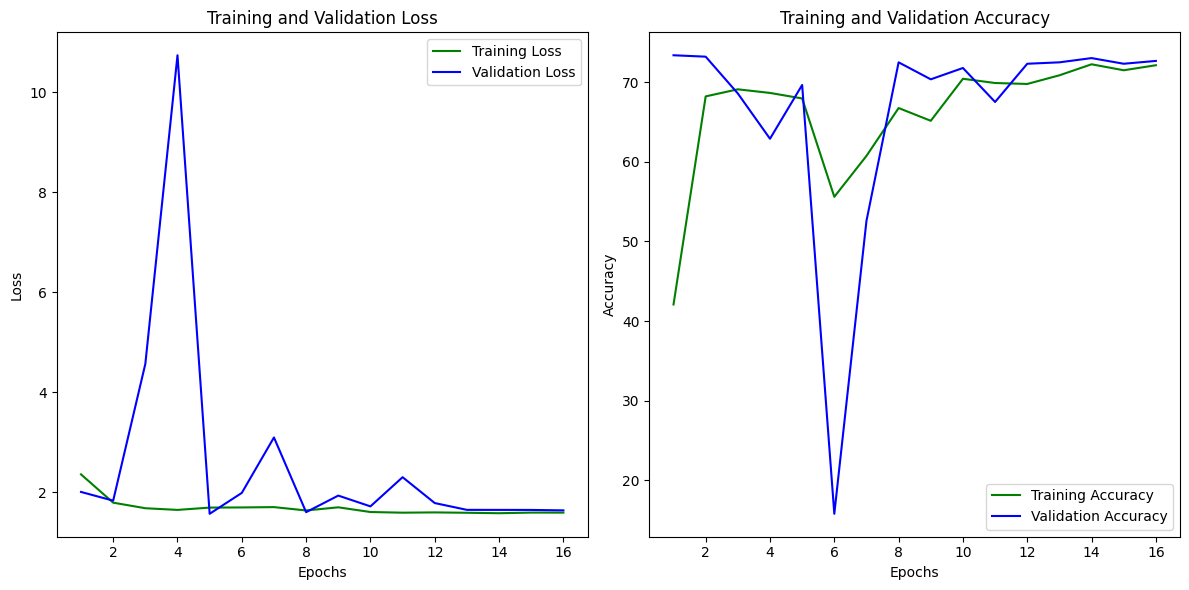


Epoch 17/50
-------------------------------
Epoch: 16, Learning Rate: 0.000050 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.773829, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 111.388036, correct predictions: 842, total: 1136
Batch 140/317 processed, running loss: 222.563471, correct predictions: 1662, total: 2256
Batch 210/317 processed, running loss: 332.067871, correct predictions: 2489, total: 3376
Batch 280/317 processed, running loss: 443.757551, correct predictions: 3257, total: 4496

Training Loss per batch = 1.582586	Accuracy on Training set = 72.441723% [3667/5062]

Validation Loss per batch = 1.611590	Accuracy on Validation set = 72.468917% [408/563]
Train Loss: 1.5826, Train Accuracy: 72.4417
Valid Loss: 1.6116, Valid Accuracy: 72.4689


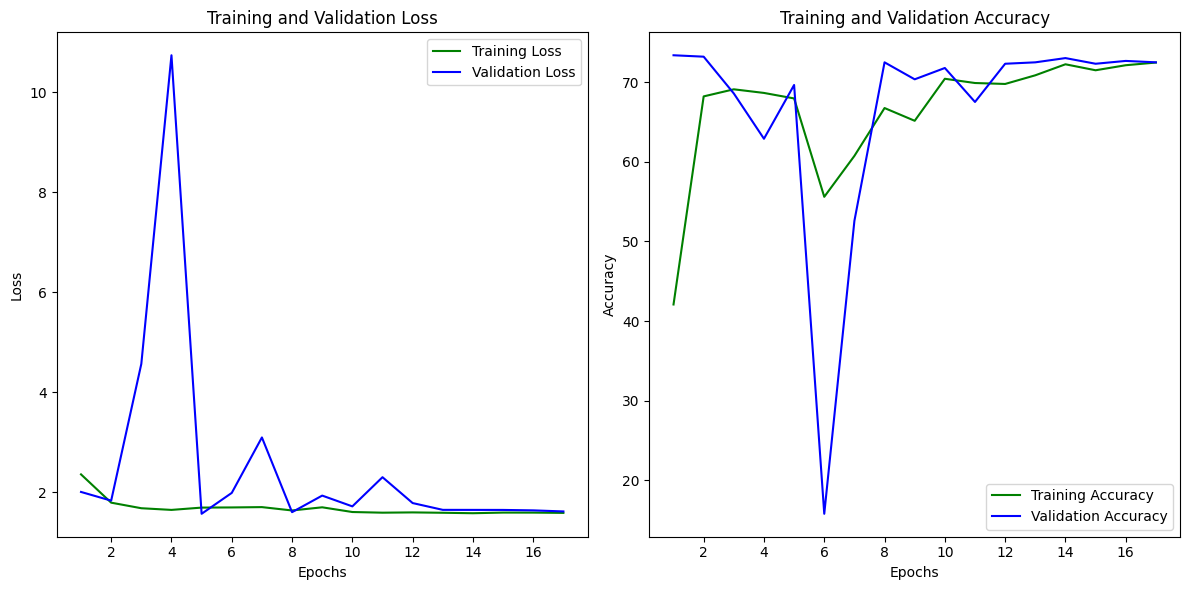


Epoch 18/50
-------------------------------
Epoch: 17, Learning Rate: 0.000005 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.416084, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 112.401636, correct predictions: 815, total: 1136
Batch 140/317 processed, running loss: 224.948726, correct predictions: 1618, total: 2256
Batch 210/317 processed, running loss: 333.992059, correct predictions: 2447, total: 3376
Batch 280/317 processed, running loss: 444.090761, correct predictions: 3261, total: 4496

Training Loss per batch = 1.583407	Accuracy on Training set = 72.323192% [3661/5062]

Validation Loss per batch = 1.627262	Accuracy on Validation set = 71.936057% [405/563]
Train Loss: 1.5834, Train Accuracy: 72.3232
Valid Loss: 1.6273, Valid Accuracy: 71.9361


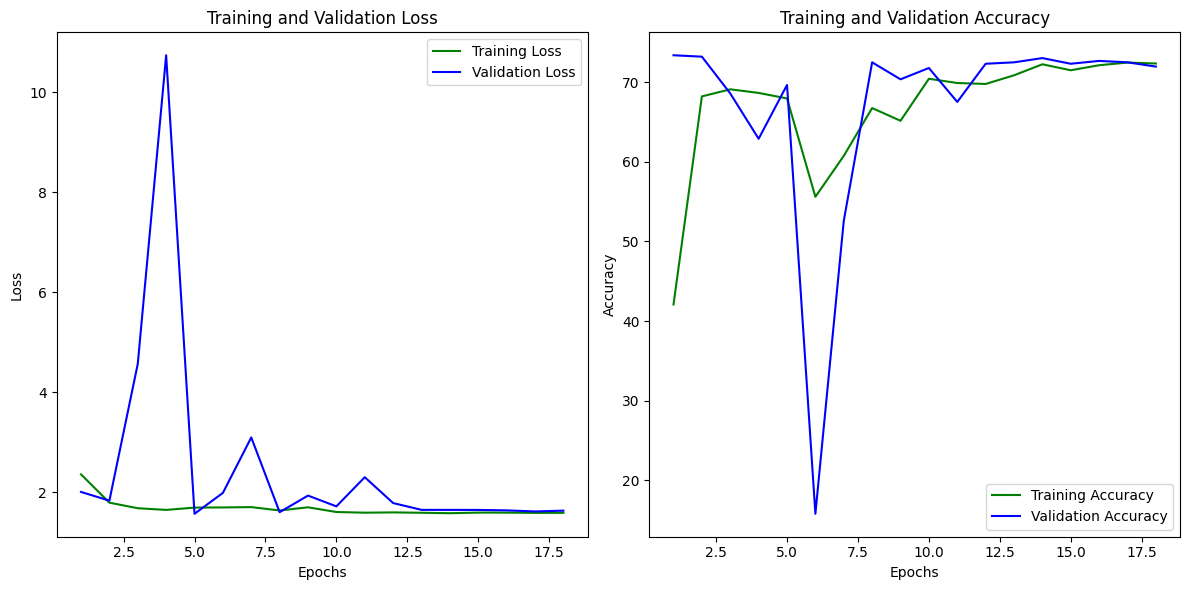


Epoch 19/50
-------------------------------
Epoch: 18, Learning Rate: 0.000005 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.462927, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 111.485525, correct predictions: 831, total: 1136
Batch 140/317 processed, running loss: 223.710797, correct predictions: 1612, total: 2256
Batch 210/317 processed, running loss: 334.377541, correct predictions: 2416, total: 3376
Batch 280/317 processed, running loss: 444.585762, correct predictions: 3238, total: 4496

Training Loss per batch = 1.582132	Accuracy on Training set = 72.086132% [3649/5062]

Validation Loss per batch = 1.603827	Accuracy on Validation set = 72.468917% [408/563]
Train Loss: 1.5821, Train Accuracy: 72.0861
Valid Loss: 1.6038, Valid Accuracy: 72.4689


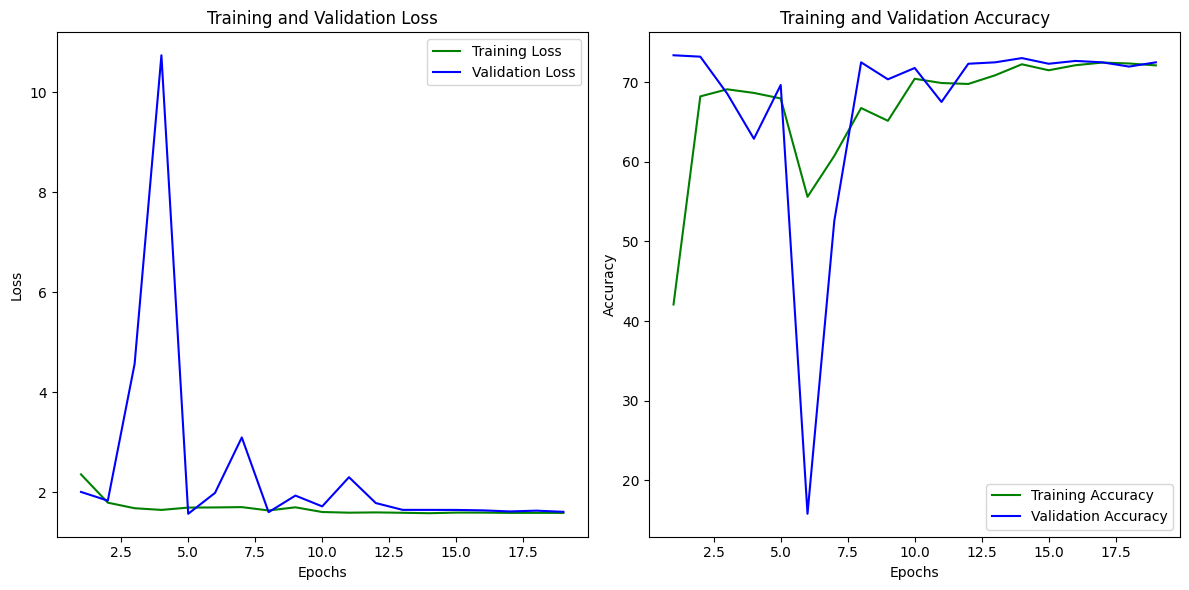


Epoch 20/50
-------------------------------
Epoch: 19, Learning Rate: 0.000005 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.805396, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 111.919432, correct predictions: 797, total: 1136
Batch 140/317 processed, running loss: 222.414847, correct predictions: 1635, total: 2256
Batch 210/317 processed, running loss: 333.511423, correct predictions: 2452, total: 3376
Batch 280/317 processed, running loss: 442.735104, correct predictions: 3260, total: 4496

Training Loss per batch = 1.580762	Accuracy on Training set = 72.323192% [3661/5062]

Validation Loss per batch = 1.641367	Accuracy on Validation set = 72.113677% [406/563]
Train Loss: 1.5808, Train Accuracy: 72.3232
Valid Loss: 1.6414, Valid Accuracy: 72.1137


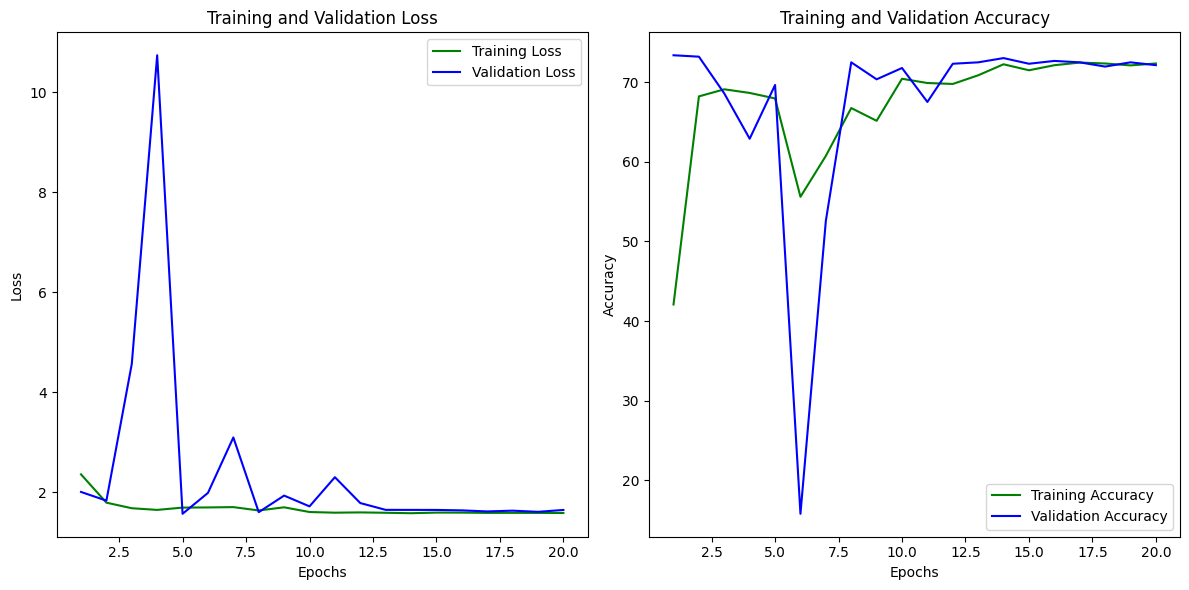


Epoch 21/50
-------------------------------
Epoch: 20, Learning Rate: 0.000005 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.500956, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 110.828625, correct predictions: 835, total: 1136
Batch 140/317 processed, running loss: 223.225064, correct predictions: 1638, total: 2256
Batch 210/317 processed, running loss: 333.838293, correct predictions: 2448, total: 3376
Batch 280/317 processed, running loss: 443.189106, correct predictions: 3270, total: 4496

Training Loss per batch = 1.583043	Accuracy on Training set = 72.481233% [3669/5062]

Validation Loss per batch = 1.596820	Accuracy on Validation set = 72.646536% [409/563]
Train Loss: 1.5830, Train Accuracy: 72.4812
Valid Loss: 1.5968, Valid Accuracy: 72.6465


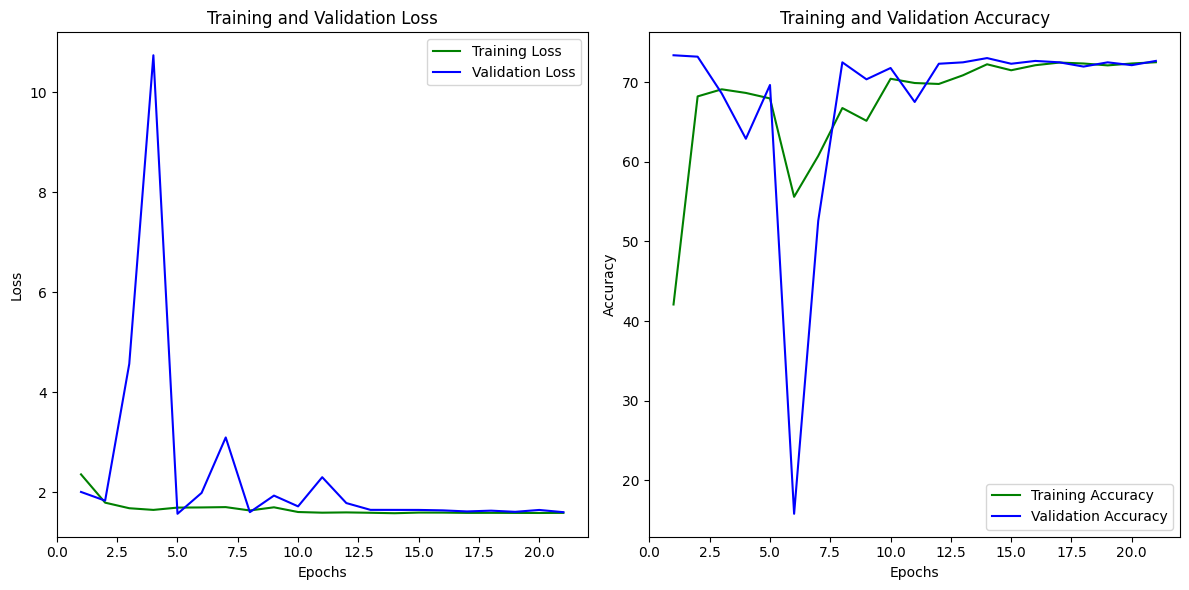


Epoch 22/50
-------------------------------
Epoch: 21, Learning Rate: 0.000001 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.536392, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 111.850363, correct predictions: 819, total: 1136
Batch 140/317 processed, running loss: 221.436469, correct predictions: 1633, total: 2256
Batch 210/317 processed, running loss: 333.642825, correct predictions: 2433, total: 3376
Batch 280/317 processed, running loss: 443.837397, correct predictions: 3247, total: 4496

Training Loss per batch = 1.579557	Accuracy on Training set = 72.560253% [3673/5062]

Validation Loss per batch = 1.603900	Accuracy on Validation set = 72.646536% [409/563]
Train Loss: 1.5796, Train Accuracy: 72.5603
Valid Loss: 1.6039, Valid Accuracy: 72.6465


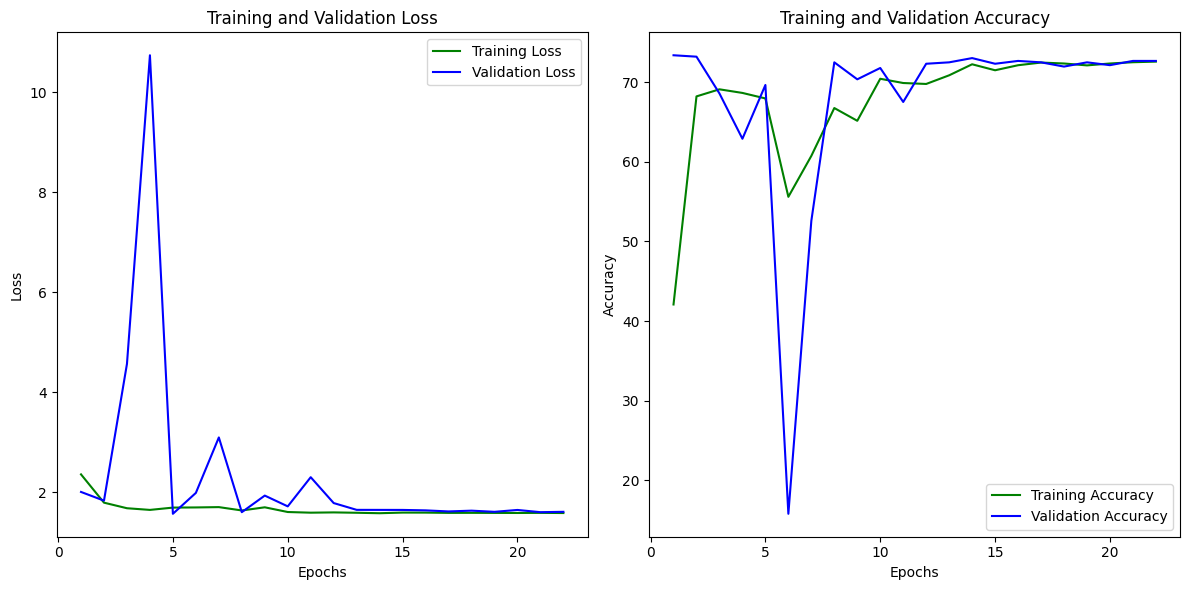


Epoch 23/50
-------------------------------
Epoch: 22, Learning Rate: 0.000001 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.617530, correct predictions: 5, total: 16
Batch 70/317 processed, running loss: 110.768173, correct predictions: 836, total: 1136
Batch 140/317 processed, running loss: 222.994261, correct predictions: 1621, total: 2256
Batch 210/317 processed, running loss: 332.960500, correct predictions: 2432, total: 3376
Batch 280/317 processed, running loss: 443.884015, correct predictions: 3249, total: 4496

Training Loss per batch = 1.579418	Accuracy on Training set = 72.382458% [3664/5062]

Validation Loss per batch = 1.583482	Accuracy on Validation set = 73.001776% [411/563]
Train Loss: 1.5794, Train Accuracy: 72.3825
Valid Loss: 1.5835, Valid Accuracy: 73.0018


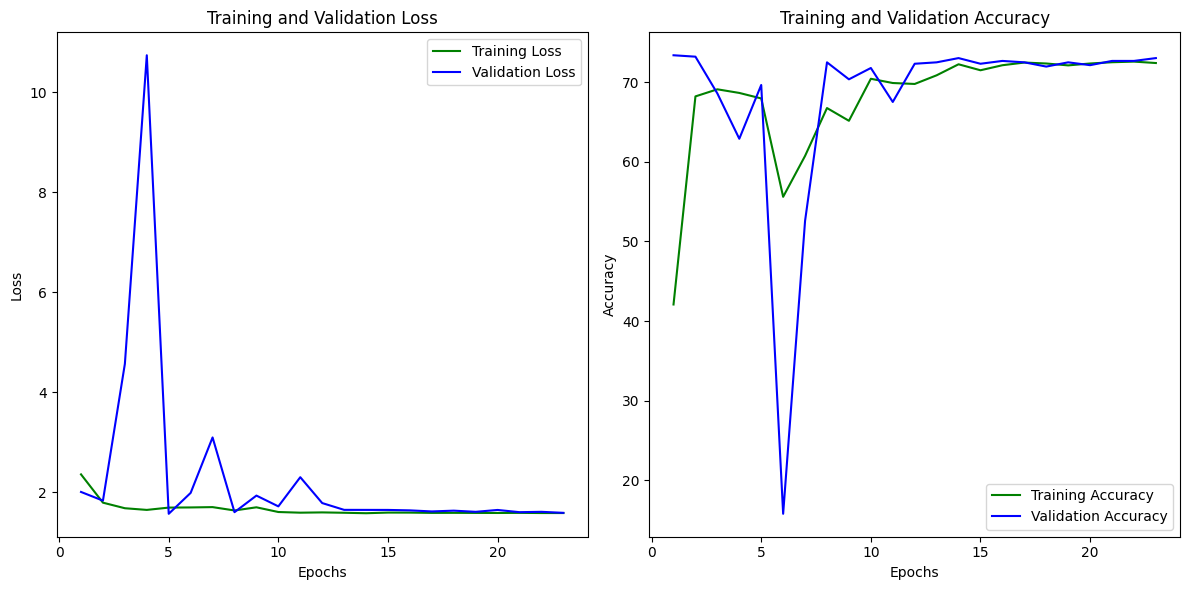


Epoch 24/50
-------------------------------
Epoch: 23, Learning Rate: 0.000001 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.648211, correct predictions: 8, total: 16
Batch 70/317 processed, running loss: 112.509794, correct predictions: 832, total: 1136
Batch 140/317 processed, running loss: 222.953491, correct predictions: 1641, total: 2256
Batch 210/317 processed, running loss: 333.635373, correct predictions: 2458, total: 3376
Batch 280/317 processed, running loss: 444.586492, correct predictions: 3260, total: 4496

Training Loss per batch = 1.584649	Accuracy on Training set = 72.303437% [3660/5062]

Validation Loss per batch = 1.636318	Accuracy on Validation set = 71.936057% [405/563]
Train Loss: 1.5846, Train Accuracy: 72.3034
Valid Loss: 1.6363, Valid Accuracy: 71.9361


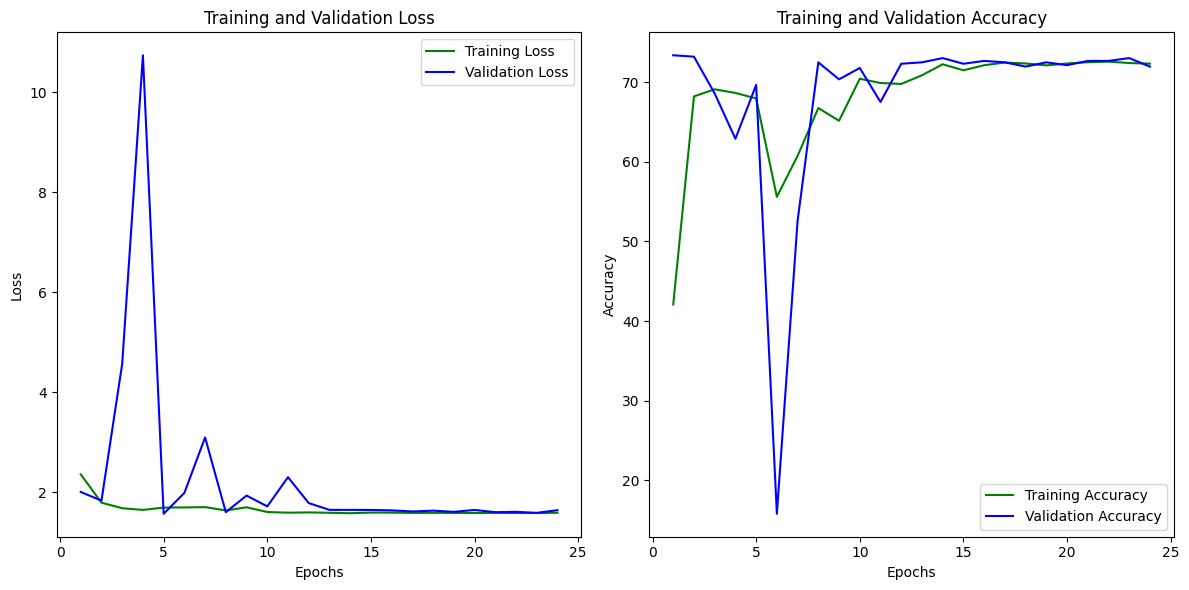


Epoch 25/50
-------------------------------
Epoch: 24, Learning Rate: 0.000001 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.740499, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 112.185398, correct predictions: 826, total: 1136
Batch 140/317 processed, running loss: 223.241389, correct predictions: 1641, total: 2256
Batch 210/317 processed, running loss: 332.354824, correct predictions: 2460, total: 3376
Batch 280/317 processed, running loss: 444.236030, correct predictions: 3268, total: 4496

Training Loss per batch = 1.582466	Accuracy on Training set = 72.382458% [3664/5062]

Validation Loss per batch = 1.584481	Accuracy on Validation set = 73.357016% [413/563]
Train Loss: 1.5825, Train Accuracy: 72.3825
Valid Loss: 1.5845, Valid Accuracy: 73.3570


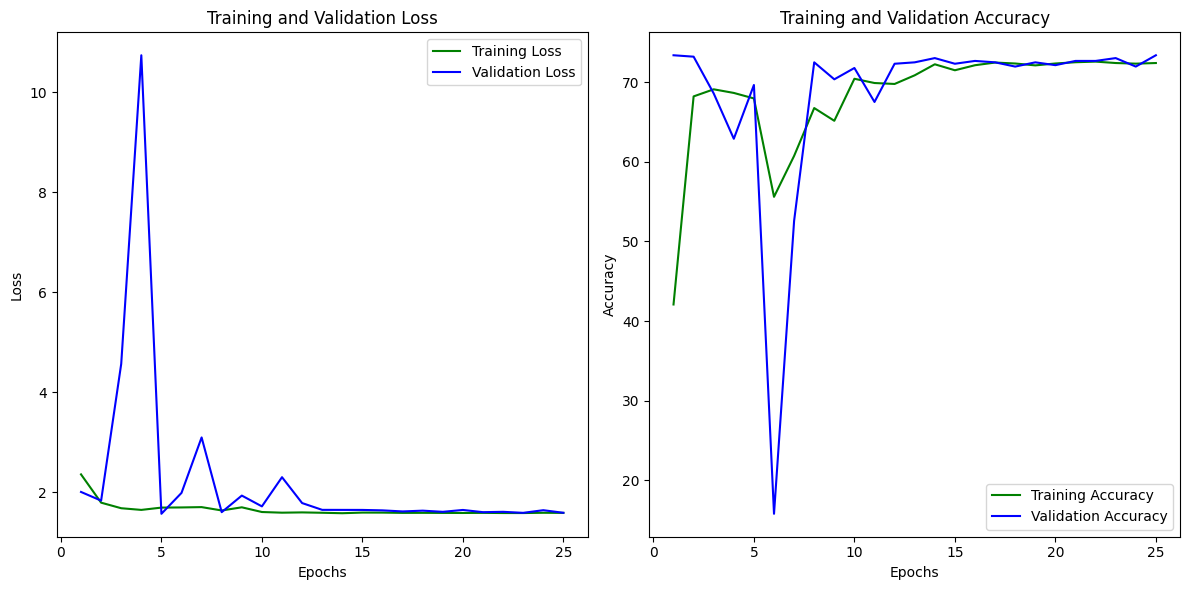


Epoch 26/50
-------------------------------
Epoch: 25, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.579216, correct predictions: 7, total: 16
Batch 70/317 processed, running loss: 110.244621, correct predictions: 801, total: 1136
Batch 140/317 processed, running loss: 224.098667, correct predictions: 1609, total: 2256
Batch 210/317 processed, running loss: 335.521797, correct predictions: 2428, total: 3376
Batch 280/317 processed, running loss: 444.543146, correct predictions: 3243, total: 4496

Training Loss per batch = 1.582312	Accuracy on Training set = 72.105887% [3650/5062]

Validation Loss per batch = 1.606993	Accuracy on Validation set = 72.646536% [409/563]
Train Loss: 1.5823, Train Accuracy: 72.1059
Valid Loss: 1.6070, Valid Accuracy: 72.6465


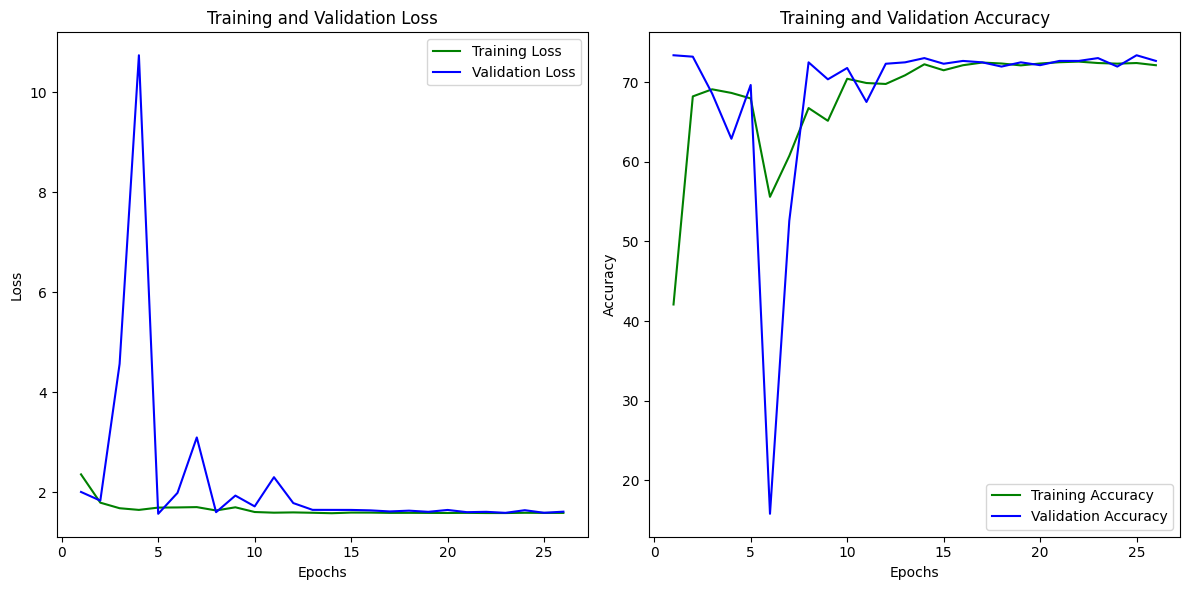


Epoch 27/50
-------------------------------
Epoch: 26, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.453480, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 112.473894, correct predictions: 835, total: 1136
Batch 140/317 processed, running loss: 224.299913, correct predictions: 1634, total: 2256
Batch 210/317 processed, running loss: 333.469727, correct predictions: 2437, total: 3376
Batch 280/317 processed, running loss: 445.474114, correct predictions: 3259, total: 4496

Training Loss per batch = 1.582774	Accuracy on Training set = 72.263927% [3658/5062]

Validation Loss per batch = 1.627343	Accuracy on Validation set = 72.468917% [408/563]
Train Loss: 1.5828, Train Accuracy: 72.2639
Valid Loss: 1.6273, Valid Accuracy: 72.4689


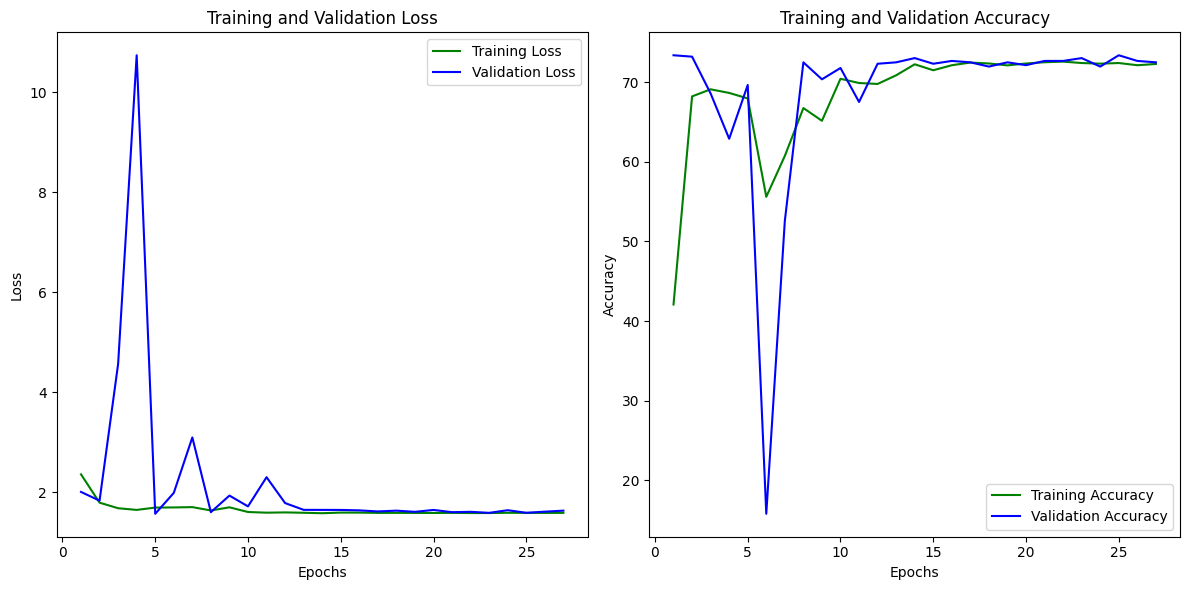


Epoch 28/50
-------------------------------
Epoch: 27, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.468773, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 113.296328, correct predictions: 843, total: 1136
Batch 140/317 processed, running loss: 223.031490, correct predictions: 1654, total: 2256
Batch 210/317 processed, running loss: 334.377777, correct predictions: 2454, total: 3376
Batch 280/317 processed, running loss: 445.287315, correct predictions: 3254, total: 4496

Training Loss per batch = 1.586955	Accuracy on Training set = 72.263927% [3658/5062]

Validation Loss per batch = 1.599603	Accuracy on Validation set = 72.646536% [409/563]
Train Loss: 1.5870, Train Accuracy: 72.2639
Valid Loss: 1.5996, Valid Accuracy: 72.6465


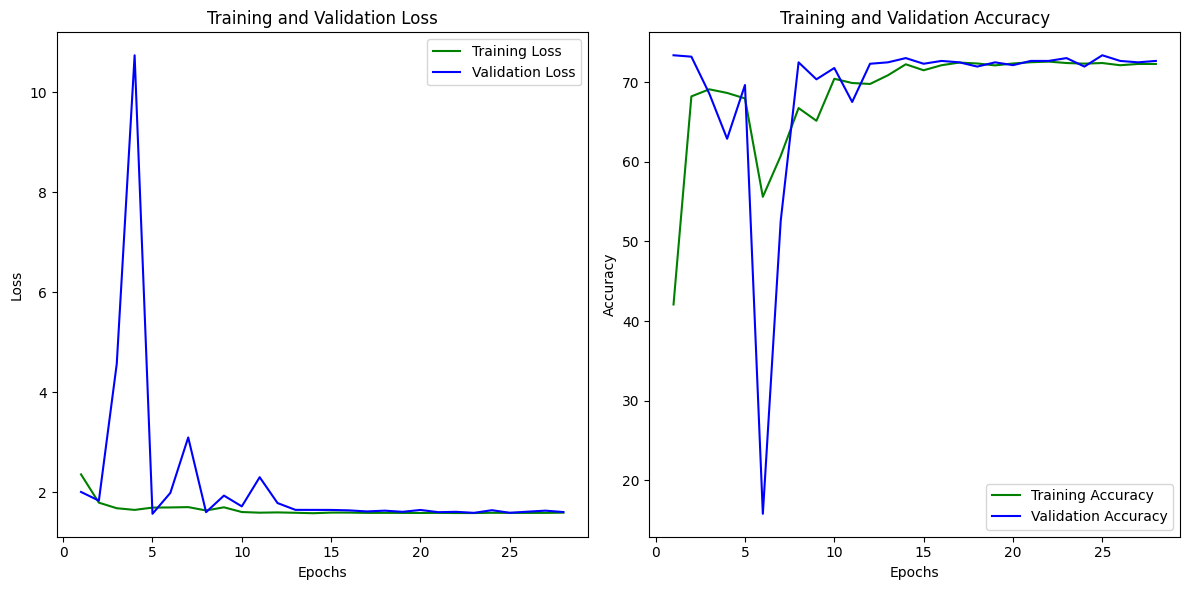


Epoch 29/50
-------------------------------
Epoch: 28, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.463494, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 111.889926, correct predictions: 830, total: 1136
Batch 140/317 processed, running loss: 220.947512, correct predictions: 1632, total: 2256
Batch 210/317 processed, running loss: 332.544346, correct predictions: 2440, total: 3376
Batch 280/317 processed, running loss: 443.295552, correct predictions: 3262, total: 4496

Training Loss per batch = 1.582444	Accuracy on Training set = 72.342947% [3662/5062]

Validation Loss per batch = 1.616084	Accuracy on Validation set = 72.646536% [409/563]
Train Loss: 1.5824, Train Accuracy: 72.3429
Valid Loss: 1.6161, Valid Accuracy: 72.6465


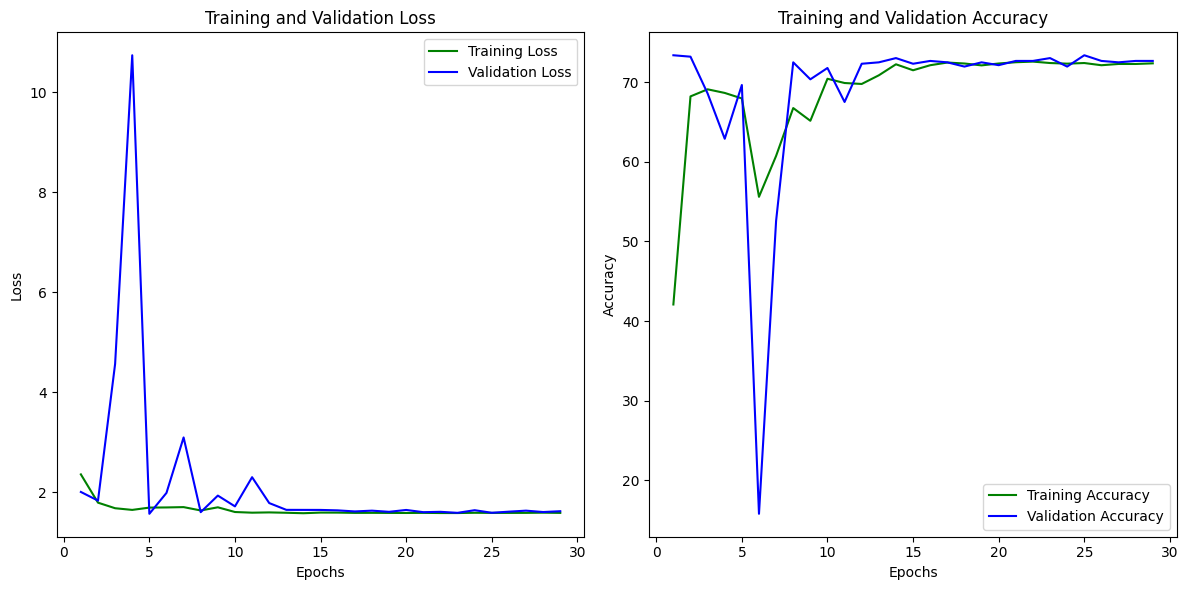


Epoch 30/50
-------------------------------
Epoch: 29, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.517087, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 110.756620, correct predictions: 825, total: 1136
Batch 140/317 processed, running loss: 222.703870, correct predictions: 1630, total: 2256
Batch 210/317 processed, running loss: 333.935070, correct predictions: 2440, total: 3376
Batch 280/317 processed, running loss: 443.388705, correct predictions: 3252, total: 4496

Training Loss per batch = 1.579752	Accuracy on Training set = 72.303437% [3660/5062]

Validation Loss per batch = 1.629799	Accuracy on Validation set = 72.291297% [407/563]
Train Loss: 1.5798, Train Accuracy: 72.3034
Valid Loss: 1.6298, Valid Accuracy: 72.2913


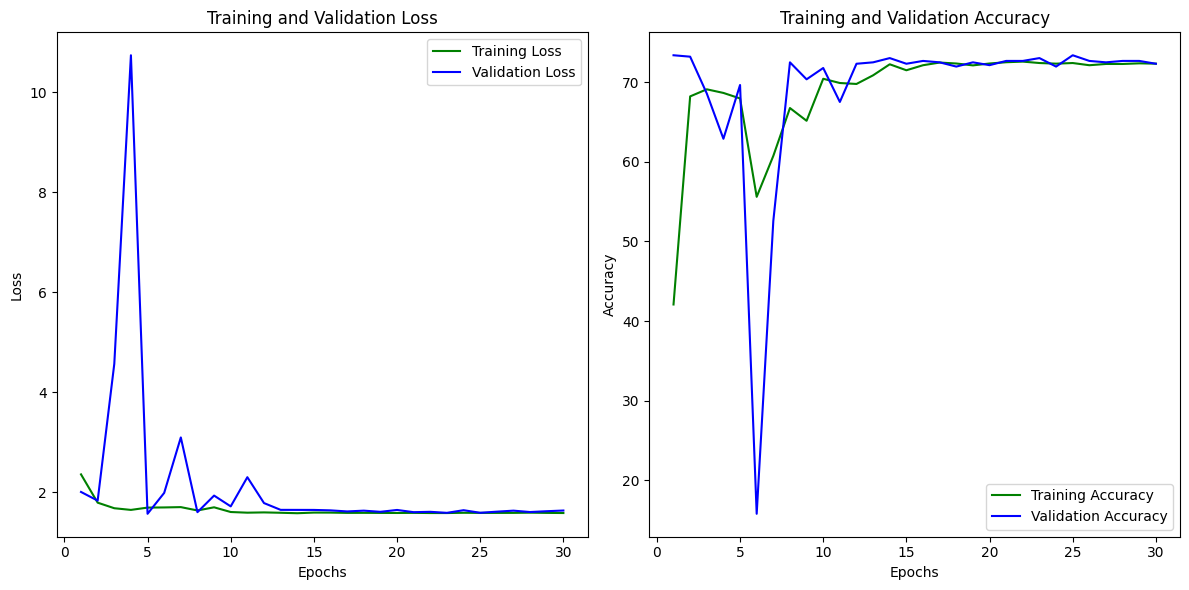


Epoch 31/50
-------------------------------
Epoch: 30, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.736239, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 113.442255, correct predictions: 825, total: 1136
Batch 140/317 processed, running loss: 223.504710, correct predictions: 1632, total: 2256
Batch 210/317 processed, running loss: 333.371246, correct predictions: 2445, total: 3376
Batch 280/317 processed, running loss: 443.069435, correct predictions: 3242, total: 4496

Training Loss per batch = 1.577006	Accuracy on Training set = 72.382458% [3664/5062]

Validation Loss per batch = 1.580747	Accuracy on Validation set = 73.534636% [414/563]
Train Loss: 1.5770, Train Accuracy: 72.3825
Valid Loss: 1.5807, Valid Accuracy: 73.5346


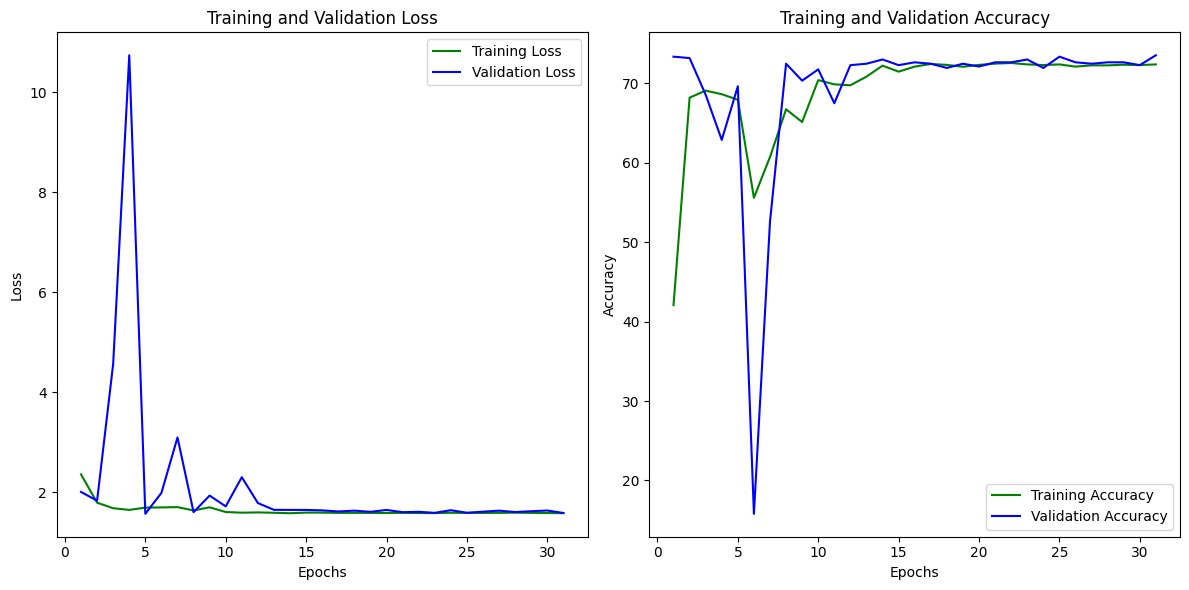


Epoch 32/50
-------------------------------
Epoch: 31, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.395339, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 112.394757, correct predictions: 842, total: 1136
Batch 140/317 processed, running loss: 222.500113, correct predictions: 1638, total: 2256
Batch 210/317 processed, running loss: 333.491234, correct predictions: 2437, total: 3376
Batch 280/317 processed, running loss: 443.929033, correct predictions: 3250, total: 4496

Training Loss per batch = 1.582390	Accuracy on Training set = 72.244172% [3657/5062]

Validation Loss per batch = 1.710892	Accuracy on Validation set = 71.403197% [402/563]
Train Loss: 1.5824, Train Accuracy: 72.2442
Valid Loss: 1.7109, Valid Accuracy: 71.4032


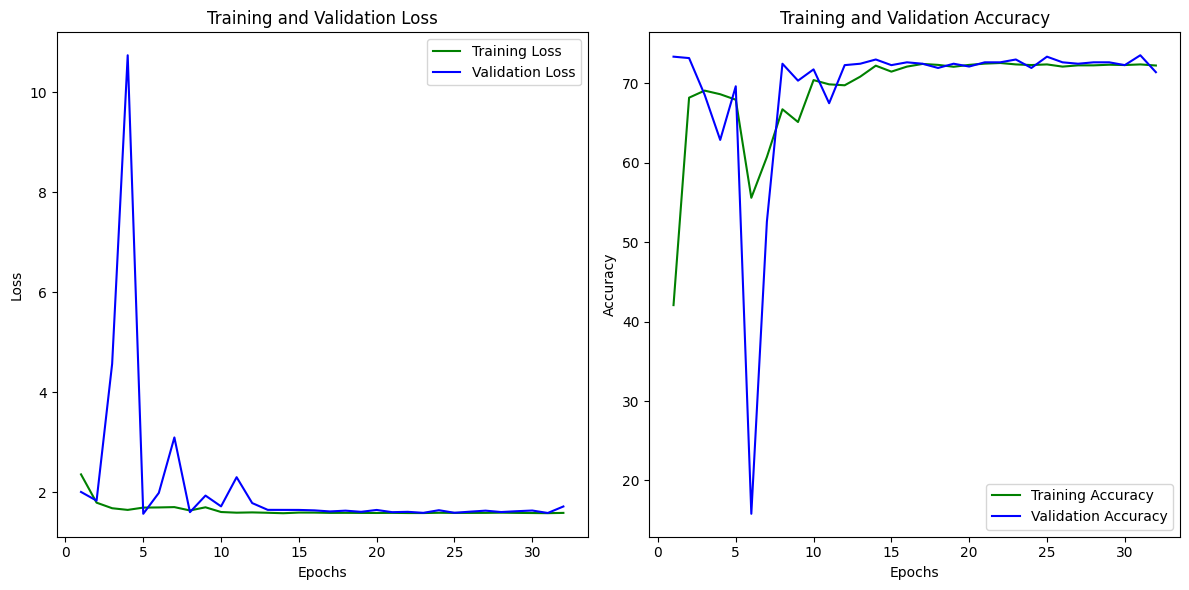


Epoch 33/50
-------------------------------
Epoch: 32, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.724155, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 110.407522, correct predictions: 834, total: 1136
Batch 140/317 processed, running loss: 220.399361, correct predictions: 1644, total: 2256
Batch 210/317 processed, running loss: 333.334419, correct predictions: 2438, total: 3376
Batch 280/317 processed, running loss: 444.481467, correct predictions: 3248, total: 4496

Training Loss per batch = 1.579304	Accuracy on Training set = 72.244172% [3657/5062]

Validation Loss per batch = 1.591331	Accuracy on Validation set = 73.357016% [413/563]
Train Loss: 1.5793, Train Accuracy: 72.2442
Valid Loss: 1.5913, Valid Accuracy: 73.3570


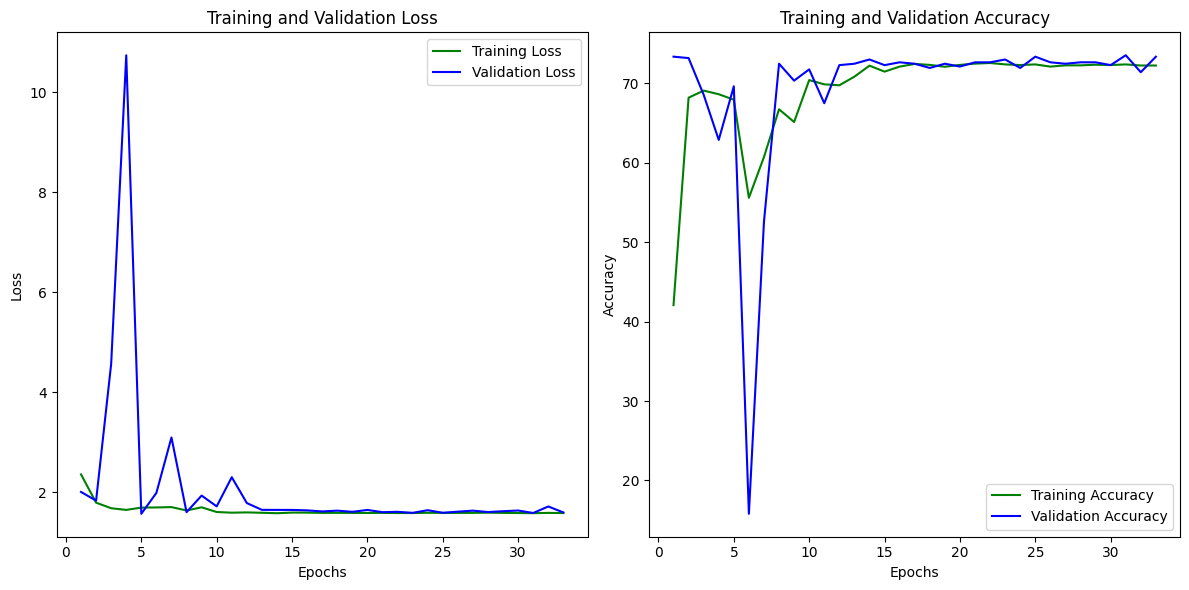


Epoch 34/50
-------------------------------
Epoch: 33, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.516022, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 112.561888, correct predictions: 823, total: 1136
Batch 140/317 processed, running loss: 225.102886, correct predictions: 1626, total: 2256
Batch 210/317 processed, running loss: 335.188537, correct predictions: 2435, total: 3376
Batch 280/317 processed, running loss: 444.277779, correct predictions: 3256, total: 4496

Training Loss per batch = 1.583040	Accuracy on Training set = 72.086132% [3649/5062]

Validation Loss per batch = 1.628813	Accuracy on Validation set = 72.646536% [409/563]
Train Loss: 1.5830, Train Accuracy: 72.0861
Valid Loss: 1.6288, Valid Accuracy: 72.6465


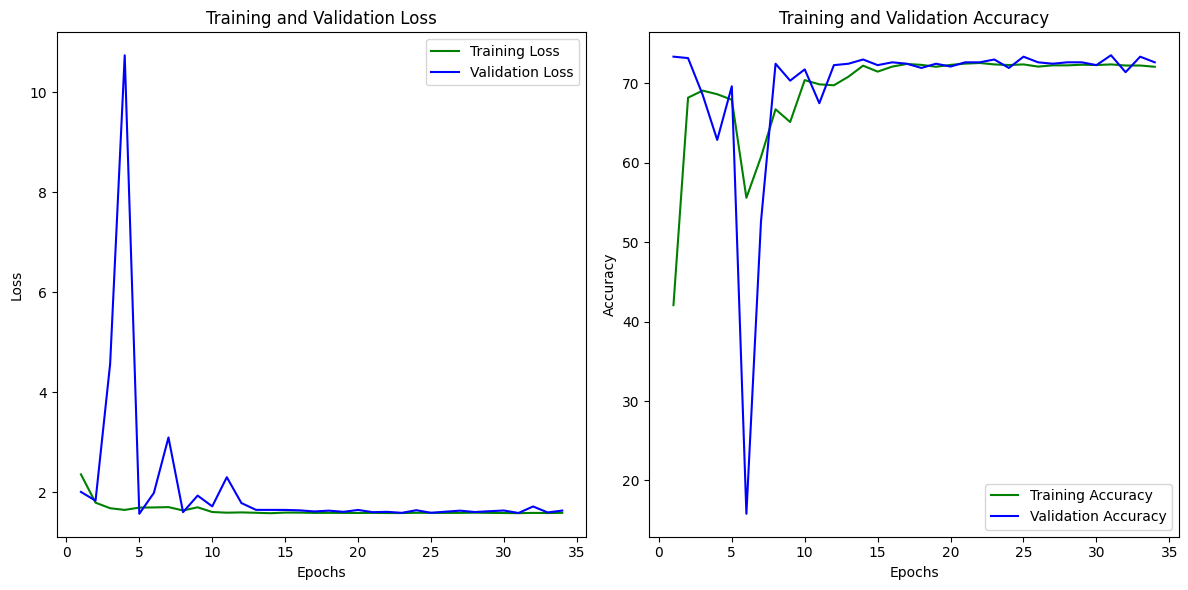


Epoch 35/50
-------------------------------
Epoch: 34, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.519252, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 111.320313, correct predictions: 822, total: 1136
Batch 140/317 processed, running loss: 220.246514, correct predictions: 1650, total: 2256
Batch 210/317 processed, running loss: 332.462385, correct predictions: 2441, total: 3376
Batch 280/317 processed, running loss: 442.506317, correct predictions: 3239, total: 4496

Training Loss per batch = 1.578747	Accuracy on Training set = 72.184907% [3654/5062]

Validation Loss per batch = 1.605759	Accuracy on Validation set = 73.001776% [411/563]
Train Loss: 1.5787, Train Accuracy: 72.1849
Valid Loss: 1.6058, Valid Accuracy: 73.0018


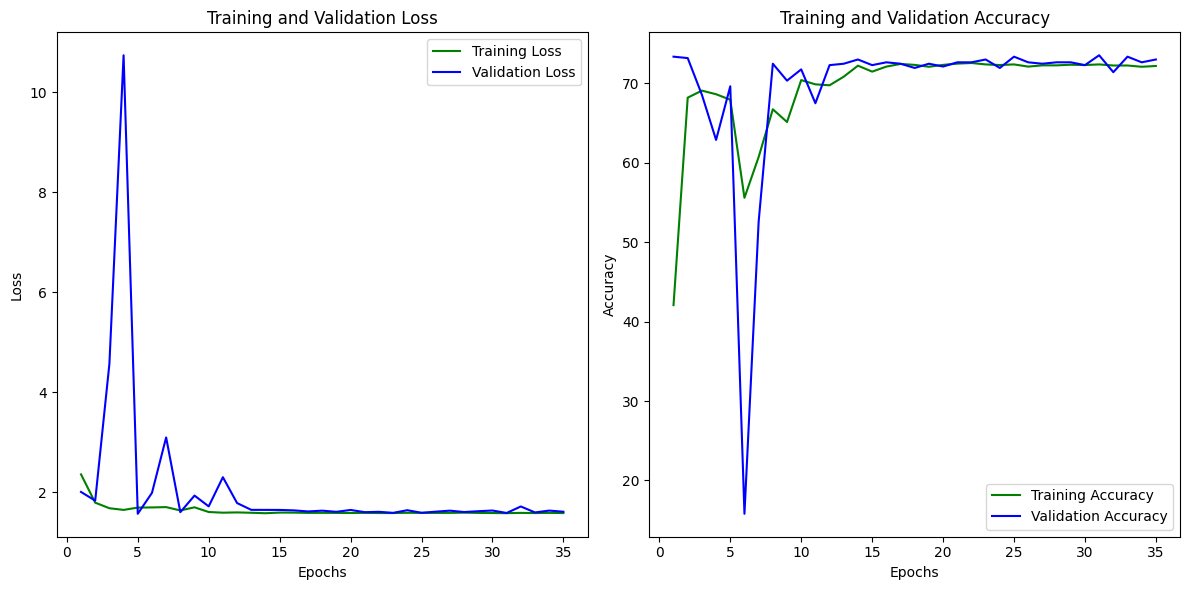


Epoch 36/50
-------------------------------
Epoch: 35, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.465574, correct predictions: 7, total: 16
Batch 70/317 processed, running loss: 111.652938, correct predictions: 824, total: 1136
Batch 140/317 processed, running loss: 221.981152, correct predictions: 1612, total: 2256
Batch 210/317 processed, running loss: 333.477343, correct predictions: 2420, total: 3376
Batch 280/317 processed, running loss: 443.176669, correct predictions: 3236, total: 4496

Training Loss per batch = 1.576088	Accuracy on Training set = 72.283682% [3659/5062]

Validation Loss per batch = 1.592527	Accuracy on Validation set = 73.179396% [412/563]
Train Loss: 1.5761, Train Accuracy: 72.2837
Valid Loss: 1.5925, Valid Accuracy: 73.1794


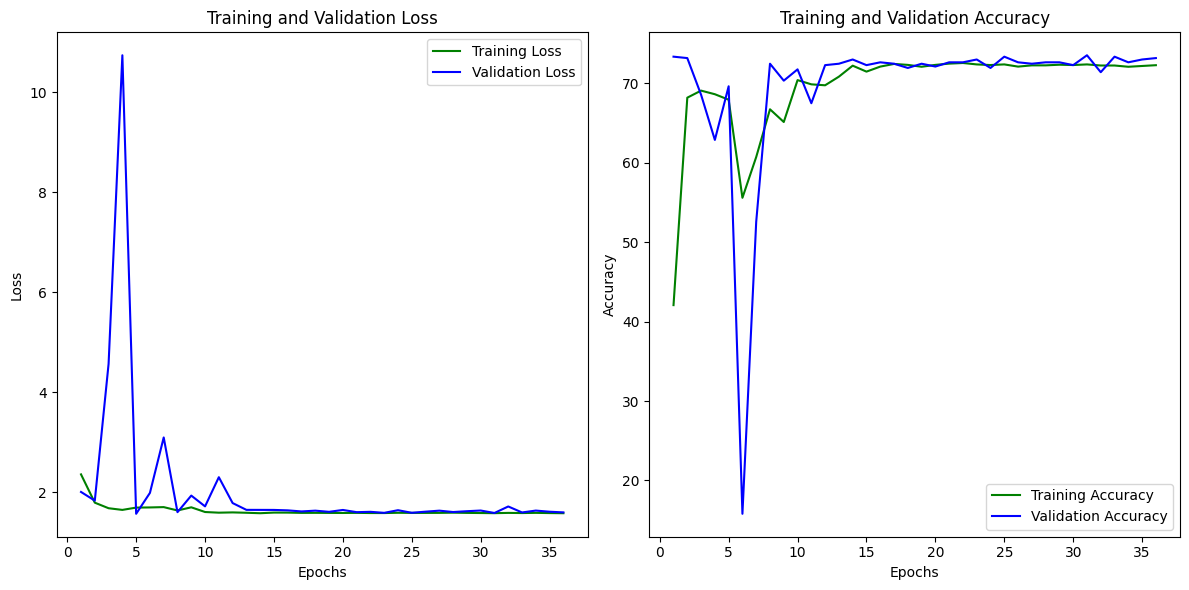


Epoch 37/50
-------------------------------
Epoch: 36, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.423300, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 111.471605, correct predictions: 839, total: 1136
Batch 140/317 processed, running loss: 222.808911, correct predictions: 1643, total: 2256
Batch 210/317 processed, running loss: 332.804860, correct predictions: 2454, total: 3376
Batch 280/317 processed, running loss: 442.944023, correct predictions: 3255, total: 4496

Training Loss per batch = 1.576326	Accuracy on Training set = 72.382458% [3664/5062]

Validation Loss per batch = 1.653067	Accuracy on Validation set = 71.758437% [404/563]
Train Loss: 1.5763, Train Accuracy: 72.3825
Valid Loss: 1.6531, Valid Accuracy: 71.7584


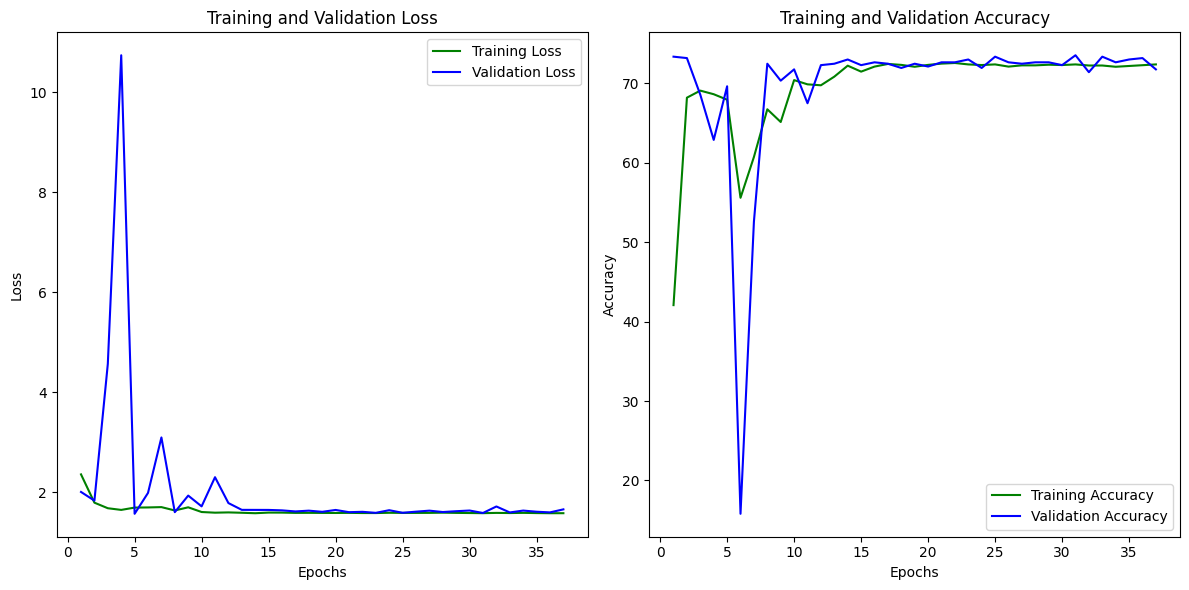


Epoch 38/50
-------------------------------
Epoch: 37, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.463201, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 111.597867, correct predictions: 834, total: 1136
Batch 140/317 processed, running loss: 222.229728, correct predictions: 1621, total: 2256
Batch 210/317 processed, running loss: 332.277717, correct predictions: 2446, total: 3376
Batch 280/317 processed, running loss: 444.043624, correct predictions: 3234, total: 4496

Training Loss per batch = 1.581059	Accuracy on Training set = 72.145397% [3652/5062]

Validation Loss per batch = 1.639609	Accuracy on Validation set = 72.291297% [407/563]
Train Loss: 1.5811, Train Accuracy: 72.1454
Valid Loss: 1.6396, Valid Accuracy: 72.2913


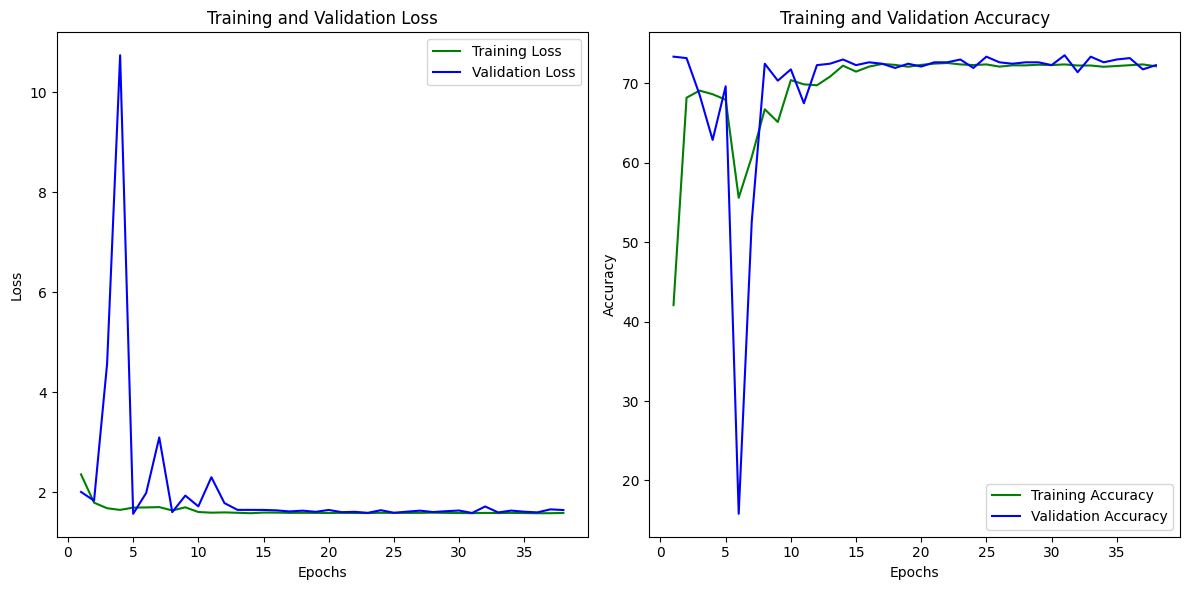


Epoch 39/50
-------------------------------
Epoch: 38, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.416143, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 112.796055, correct predictions: 822, total: 1136
Batch 140/317 processed, running loss: 223.787318, correct predictions: 1644, total: 2256
Batch 210/317 processed, running loss: 333.750460, correct predictions: 2455, total: 3376
Batch 280/317 processed, running loss: 444.158759, correct predictions: 3271, total: 4496

Training Loss per batch = 1.578647	Accuracy on Training set = 72.520743% [3671/5062]

Validation Loss per batch = 1.584671	Accuracy on Validation set = 73.179396% [412/563]
Train Loss: 1.5786, Train Accuracy: 72.5207
Valid Loss: 1.5847, Valid Accuracy: 73.1794


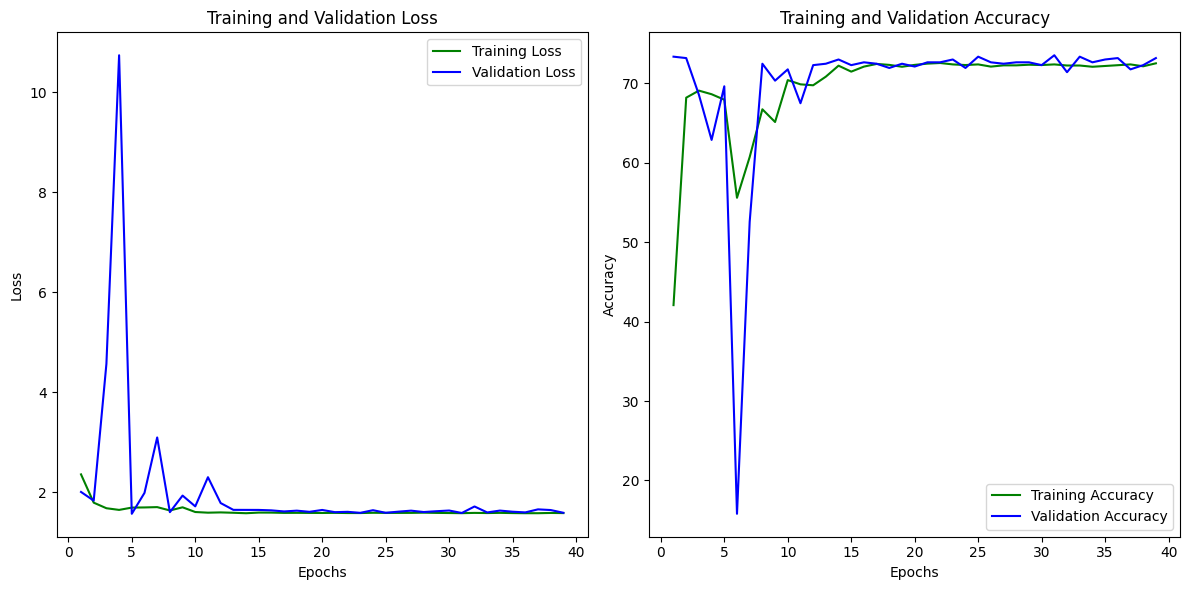


Epoch 40/50
-------------------------------
Epoch: 39, Learning Rate: 0.000000 


<ipython-input-25-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.572950, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 112.086587, correct predictions: 812, total: 1136
Batch 140/317 processed, running loss: 221.991387, correct predictions: 1630, total: 2256
Batch 210/317 processed, running loss: 334.978371, correct predictions: 2423, total: 3376
Batch 280/317 processed, running loss: 444.365343, correct predictions: 3242, total: 4496

Training Loss per batch = 1.581638	Accuracy on Training set = 72.046622% [3647/5062]

Validation Loss per batch = 1.584648	Accuracy on Validation set = 73.357016% [413/563]
Train Loss: 1.5816, Train Accuracy: 72.0466
Valid Loss: 1.5846, Valid Accuracy: 73.3570


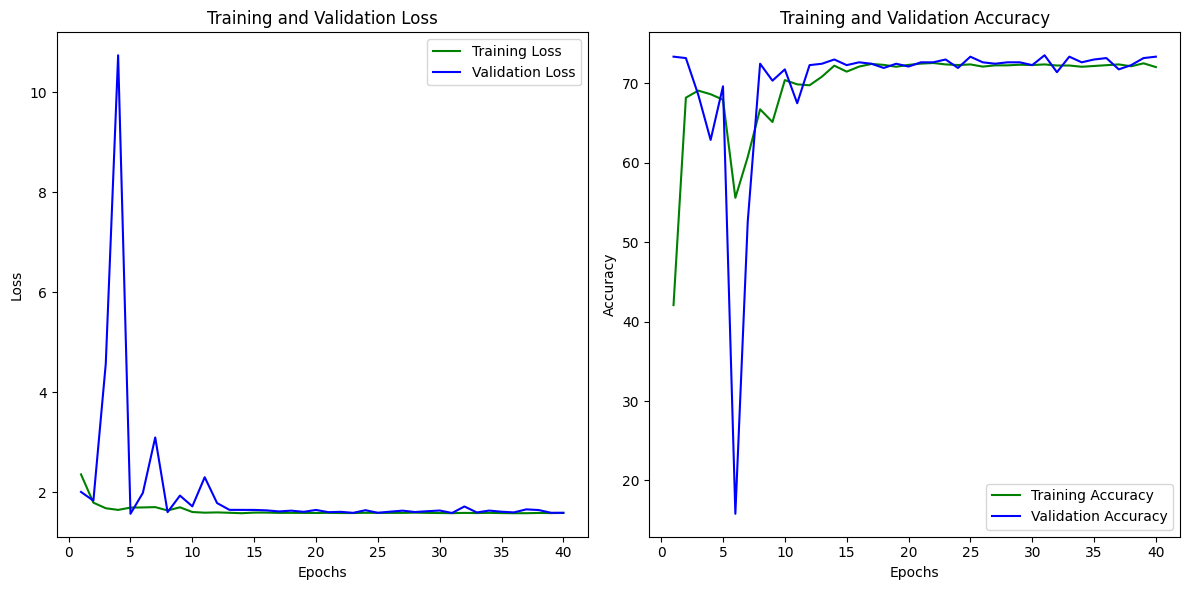

Early stopping at epoch 40, the validation loss did not improve for the last 35 epochs

Training has completed!


In [28]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
nb_epochs = 50
patience = 35

#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/unzip

In [ ]:
model = torch.load("DR_ResNet50_test.pt")
model.eval()  # Set the model to evaluation mode

# Store all the model predictions for the test set
all_preds = []
all_labels = []

# No need to track gradients for evaluation, saves memory and computations
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# For multiclass case:
num_classes = cm.shape[0]  # assuming cm is a square matrix

for i in range(num_classes):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp  # sum across the row, excluding the diagonal element
    fp = cm[:, i].sum() - tp  # sum down the column, excluding the diagonal element
    tn = cm.sum() - fn - fp - tp

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"For class {i}, Sensitivity: {sensitivity}, Specificity: {specificity}")


In [ ]:
!nvidia-smi

In [ ]:
!pwd

In [ ]:
!zip -r data.zip test train